# A notebook for comparing PIPS and TTU StickNets and using StickNet data to bias-correct the PIPS for IOP2-2022

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as feature
# from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# print(matplotlib.style.available)

matplotlib.style.use('seaborn-v0_8-bright')

def comp_plot(PIPS_names, ds_dict, varname='fasttemp', alpha=1.0, mask_below=None, x='time'):
    fig, ax = plt.subplots(figsize=(10, 10))
    for PIPS_name in PIPS_names:
        plotvar = ds_dict[PIPS_name][varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=PIPS_name, alpha=alpha, x=x)
    ax.legend(loc='best')
    return fig, ax

def comp_var_plot(ds, varnames=['pcount', 'pcount_derived'], alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for varname in varnames:
        plotvar = ds[varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=varname, alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

def comp_var_ds_plot(ds1, ds2, var1, var2, alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    plotvar1 = ds1[var1]
    plotvar2 = ds2[var2]
    if mask_below is not None:
        plotvar1 = plotvar1.where(plotvar1 > mask_below)
        plotvar2 = plotvar2.where(plotvar2 > mask_below)
    plotvar1.plot(ax=ax, label=f'{ds1.probe_name}: {var1}', alpha=alpha)
    plotvar2.plot(ax=ax, label=f'{ds2.probe_name}: {var2}', alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

# Define a formatter function to format the x-axis labels for timedeltas
def time_formatter(x, pos):
    td = pd.to_timedelta(x, unit='s')
    total_seconds = int(td.total_seconds())
    if total_seconds < 0:
        total_seconds = abs(total_seconds)
        sign = "-"
    else:
        sign = ""
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f'{sign}{hours:02}:{minutes:02}:{seconds:02}'


def adjust_time_coordinate(ds, gust_front_time, dim='time'):
    # Calculate the relative time
    relative_time = ds[dim] - gust_front_time
    relative_time = relative_time.dt.total_seconds()
    
    # Assign the new coordinate
    ds = ds.assign_coords(relative_time=relative_time)
    
    # Set the new time coordinate
    ds = ds.swap_dims({dim: 'relative_time'})
    
    # Drop the old time coordinate if desired
    # ds = ds.drop_vars('time')
    
    return ds


def read_StickNet_locs_to_xarray(filepath):
    """Given the path to the StickNet locations file, read it into an xarray Dataset"""
    df = pd.read_csv(filepath)
    ds = df.to_xarray()
    ds = ds.assign_coords(ID=('index', ds['ID'].to_numpy()))
    ds = ds.swap_dims({'index': 'ID'})

    return ds

def read_StickNet_level3_to_xarray(dir, deployment_name, probe_id, loc_ds):
    """Given the directory containing the level3 files and an xarray Dataset containing the location information,
       read the data into an xarray Dataset"""
    probe_filename = f"0{probe_id}_{deployment_name}_level3.txt"
    probe_filepath = os.path.join(dir, probe_filename)
    probe_df = pd.read_csv(probe_filepath)
    # Set the time index
    probe_df['Time'] = pd.DatetimeIndex(probe_df['Time'])
    probe_df.set_index("Time", inplace=True)
    probe_ds = probe_df.to_xarray()

    # Set location, probe id, start and end times, etc., as attributes
    probe_ds.attrs['probe_name'] = probe_id
    lat = loc_ds.sel(ID=probe_id)['Latitude'].to_numpy().item()
    lon = loc_ds.sel(ID=probe_id)['Longitude'].to_numpy().item()
    elev = loc_ds.sel(ID=probe_id)['Elevation'].to_numpy().item()
    location_tuple = (lat, lon, elev)
    probe_ds.attrs['location'] = str(location_tuple)
    probe_ds.attrs['Array_Type'] = "Fine"
    starting_time = probe_ds['Time'][0].dt.strftime("%Y%m%d%H%M%S").item()
    ending_time = probe_ds['Time'][-1].dt.strftime("%Y%m%d%H%M%S").item()
    probe_ds.attrs['starting_time'] = starting_time
    probe_ds.attrs['ending_time'] = ending_time

    return probe_ds

In [3]:
# date = '052516' # '053122' # '030622' # '061416'

PIPS_base_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/"
deployment_name = "IOP2_033022"
PIPS_dir = os.path.join(PIPS_base_dir, deployment_name, 'netcdf')
PIPS_output_dir = os.path.join(PIPS_base_dir, deployment_name, 'netcdf_bias_corrected')
if not os.path.exists(PIPS_output_dir):
    os.makedirs(PIPS_output_dir)

PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
intervalstr = f'{parsivel_interval:d}S'
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]
output_parsivel_filepaths = [os.path.join(PIPS_output_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]

conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]
output_conv_filepaths = [os.path.join(PIPS_output_dir, conv_filename) for conv_filename in conv_filenames]

parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [4]:
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_read_dict[PIPS_name]
    print(parsivel_ds['time'][0], parsivel_ds['time'][-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:50:13.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:50:13
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:25:23.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:25:23
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:42:43.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:42:43
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:30:33.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:30:33
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:59:33.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:59:33
    flagged_times  int64 

In [5]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
start_time = '2023-03-16T17:45'
end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [6]:
parsivel_ds_dict['PIPS1A']

<xarray.Dataset> Size: 16MB
Dimensions:                    (time: 572, fallspeed_bin: 32, diameter_bin: 32,
                                parameter: 3, fields_KGWX: 27)
Coordinates:
  * time                       (time) datetime64[ns] 5kB 2022-03-30T23:50:13 ...
    fallspeed                  (fallspeed_bin) float64 256B 0.05 0.15 ... 20.8
    diameter                   (diameter_bin) float64 256B 0.0625 ... 24.5
    min_diameter               (diameter_bin) float64 256B 0.0 0.125 ... 23.0
    max_diameter               (diameter_bin) float64 256B 0.125 0.25 ... 26.0
    min_fallspeeds             (fallspeed_bin) float64 256B 0.0 0.1 ... 19.2
    max_fallspeeds             (fallspeed_bin) float64 256B 0.1 0.2 ... 22.4
    flagged_times              (time) int64 5kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
  * parameter                  (parameter) <U5 60B 'N0' 'lamda' 'alpha'
  * fields_KGWX                (fields_KGWX) <U13 1kB 'REF' ... 'Dm43_Z01_4dB'
Dimensions without coordinates: fallspeed_bin, diameter_bin
Data variables: (12/140)
    precipintensity            (time) float64 5kB 6.557 6.884 ... 5.461 5.681
    precipaccum                (time) float64 5kB 0.09 0.11 0.13 ... 34.6 34.62
    parsivel_dBZ               (time) float64 5kB 37.81 37.95 ... 38.01 36.59
    sample_interval            (time) timedelta64[ns] 5kB 00:00:10 ... 00:00:10
    signal_amplitude           (time) float64 5kB 2.004e+04 ... 1.243e+04
    pcount                     (time) int64 5kB 58 57 48 54 55 ... 45 49 47 46
    ...                         ...
    W_retr_Z01_4dB_roqc        (time) float64 5kB 0.4436 0.3844 ... 0.3922
    sigma_retr_Z01_4dB_roqc    (time) float64 5kB 0.6579 0.7191 ... 0.7838 0.605
    Dm43_retr_Z01_4dB_roqc     (time) float64 5kB 1.678 1.759 ... 1.846 1.608
    ND_retr_Z01_4dB_roqc       (time, diameter_bin) float64 146kB 0.0 ... nan
    KGWX_beam_height_at_PIPS   (time) float64 5kB 282.1 279.3 ... 287.6 286.0
    KGWX_at_PIPS               (time, fields_KGWX) float64 124kB 33.88 ... 1.443
Attributes:
    nominal sample interval:  10 seconds
    probe_name:               PIPS1A
    parsivel_angle:           -45.0
    deployment_name:          IOP2_033022
    location:                 (33.758010564407854, -88.44616666666666, 70.743...
    starting_time:            20220330235013
    ending_time:              20220331012523
    DSD_interval:             10.0
    retrieval_wavelength:     10.7
    CG_coeff_Z01:             [-1.957  1.213 -0.016]
    CG_coeff_Z01_4dB:         [-1.957  1.213 -0.016]

In [7]:
# Read in StickNet data (level 3)

stick_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/TTU_StickNet"
IOP_name = "IOP2"

location_file = f"{IOP_name}_StickNet_Locations.csv"
location_path = os.path.join(stick_dir, location_file)

sticknet_locs_ds = read_StickNet_locs_to_xarray(location_path)
sticknet_fine_locs_ds = sticknet_locs_ds.where(sticknet_locs_ds['Array_Type'] == 'Fine', drop=True)

In [8]:
sticknet_fine_locs_ds

<xarray.Dataset> Size: 384B
Dimensions:     (ID: 8)
Coordinates:
  * ID          (ID) object 64B '103A' '104A' '110A' ... '214A' '220A' '221A'
    index       (ID) int64 64B 2 3 9 10 12 13 19 20
Data variables:
    Latitude    (ID) float64 64B 33.71 33.82 33.76 33.79 33.77 33.8 33.73 33.74
    Longitude   (ID) float64 64B -88.45 -88.46 -88.45 ... -88.46 -88.44 -88.44
    Elevation   (ID) float64 64B 72.4 73.8 76.8 68.9 71.4 70.4 87.2 81.8
    Array_Type  (ID) object 64B 'Fine' 'Fine' 'Fine' ... 'Fine' 'Fine' 'Fine'

In [9]:
sticknet_fine_ids = sticknet_fine_locs_ds['ID'].to_numpy()

sticknet_ds_list = [read_StickNet_level3_to_xarray(stick_dir, IOP_name, probe_id, sticknet_fine_locs_ds) for probe_id in sticknet_fine_ids]
sticknet_ds_dict = {stick_id: stick_ds for stick_id, stick_ds in zip(sticknet_fine_ids, sticknet_ds_list)}

In [10]:
sticknet_ds_dict['103A']

<xarray.Dataset> Size: 355kB
Dimensions:  (Time: 7402)
Coordinates:
  * Time     (Time) datetime64[ns] 59kB 2022-03-30T23:43:00 ... 2022-03-31T01...
Data variables:
    T        (Time) float64 59kB 21.8 21.8 21.9 21.9 ... 17.2 17.2 17.2 17.2
    RH       (Time) float64 59kB 81.3 81.4 81.5 81.5 ... 93.0 93.0 93.0 93.0
    P        (Time) float64 59kB 991.9 992.0 992.0 991.9 ... 993.5 993.5 993.5
    WS       (Time) float64 59kB 5.8 5.4 5.2 5.2 6.6 6.2 ... 3.2 3.2 3.2 3.2 3.2
    WD       (Time) float64 59kB 173.3 169.5 174.2 202.0 ... 179.5 167.6 180.0
Attributes:
    probe_name:     103A
    location:       (33.714987, -88.450477, 72.4)
    Array_Type:     Fine
    starting_time:  20220330234300
    ending_time:    20220331014621

In [11]:
conv_ds_dict['PIPS1A']

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 5711)
Coordinates:
  * time           (time) datetime64[ns] 46kB 2022-03-30T23:50:13 ... 2022-03...
Data variables: (12/25)
    voltage        (time) float64 46kB 12.66 12.66 12.66 ... 12.53 12.53 12.53
    winddirrel     (time) float64 46kB 186.0 186.0 189.0 ... 204.0 202.0 209.0
    windspd        (time) float64 46kB 3.44 4.2 4.01 3.32 ... 2.22 1.91 1.4 1.71
    winddiag       (time) float64 46kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fasttemp       (time) float64 46kB 20.72 20.72 20.75 ... 16.87 16.87 16.86
    slowtemp       (time) float64 46kB 21.69 21.72 21.63 ... 16.77 16.83 16.75
    ...             ...
    dewpoint       (time) float64 46kB 18.68 18.74 18.66 ... 16.13 16.2 16.12
    RH_derived     (time) float64 46kB 88.09 88.46 87.82 ... 95.39 95.86 95.43
    pt             (time) float64 46kB 294.6 294.6 294.6 ... 290.5 290.5 290.5
    qv             (time) float64 46kB 0.01367 0.01373 ... 0.01165 0.01159
    rho            (time) float64 46kB 1.166 1.166 1.166 ... 1.186 1.186 1.186
    missing_times  (time) int64 46kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    probe_name:       PIPS1A
    parsivel_angle:   -45.0
    deployment_name:  IOP2_033022
    location:         (33.758010564407854, -88.44616666666666, 70.74344247942...
    starting_time:    20220330235013
    ending_time:      20220331012523

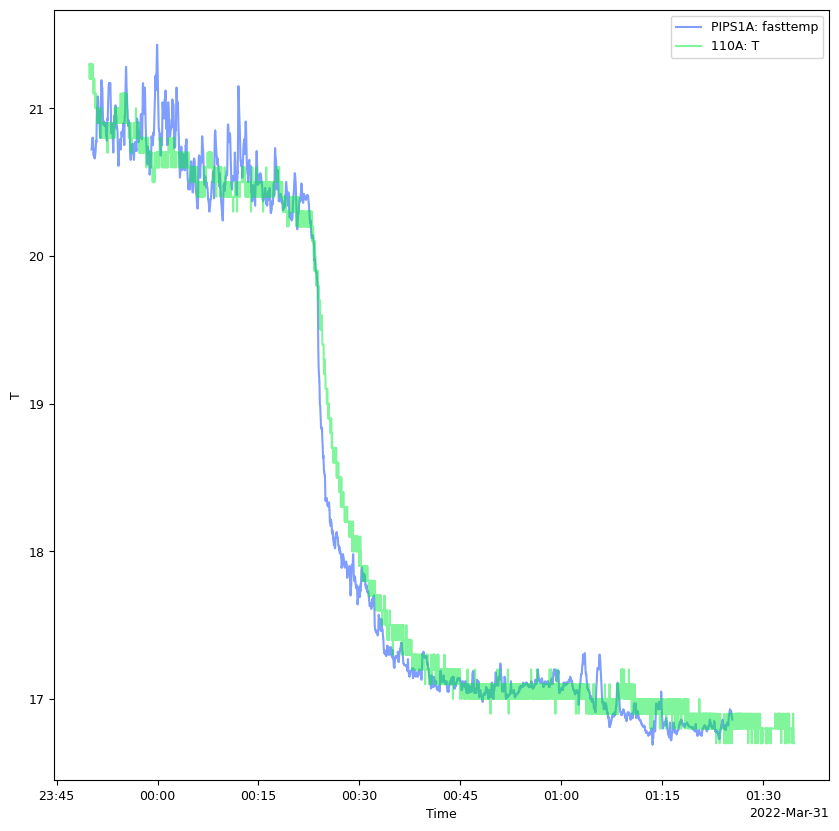

In [12]:
# Plot temperature for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'fasttemp', 'T', alpha=0.5)

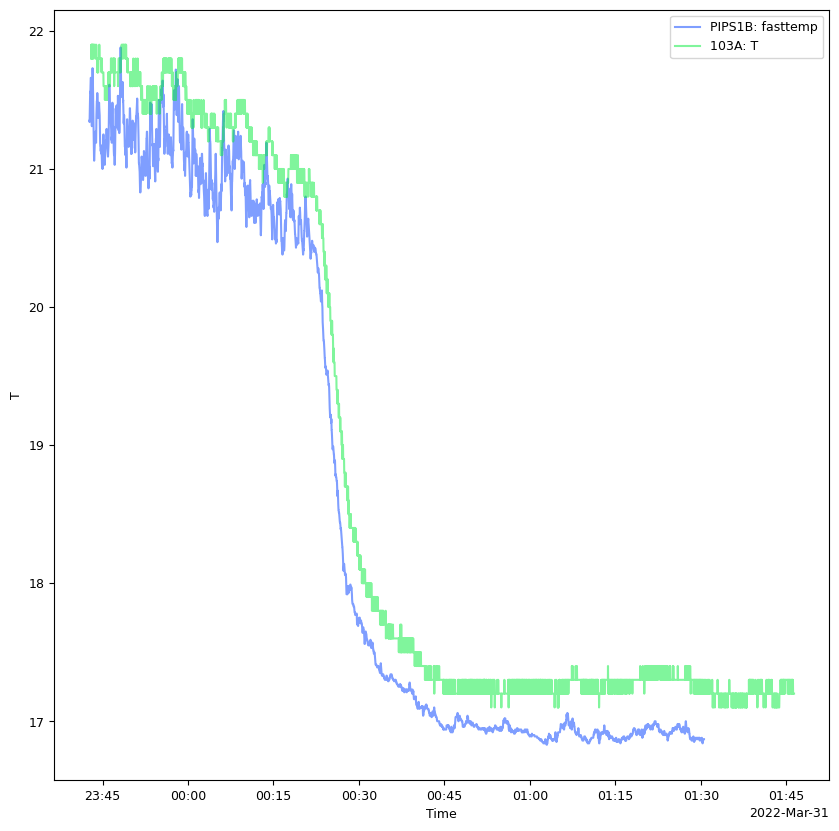

In [13]:
# Plot temperature for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'fasttemp', 'T', alpha=0.5)

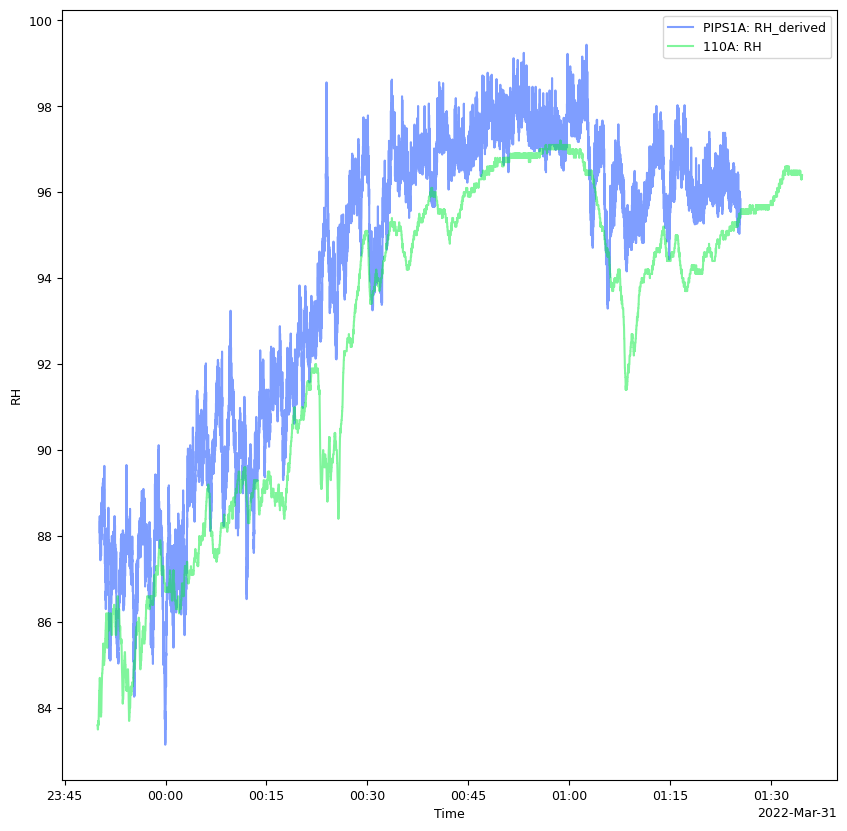

In [14]:
# Plot RH for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'RH_derived', 'RH', alpha=0.5)

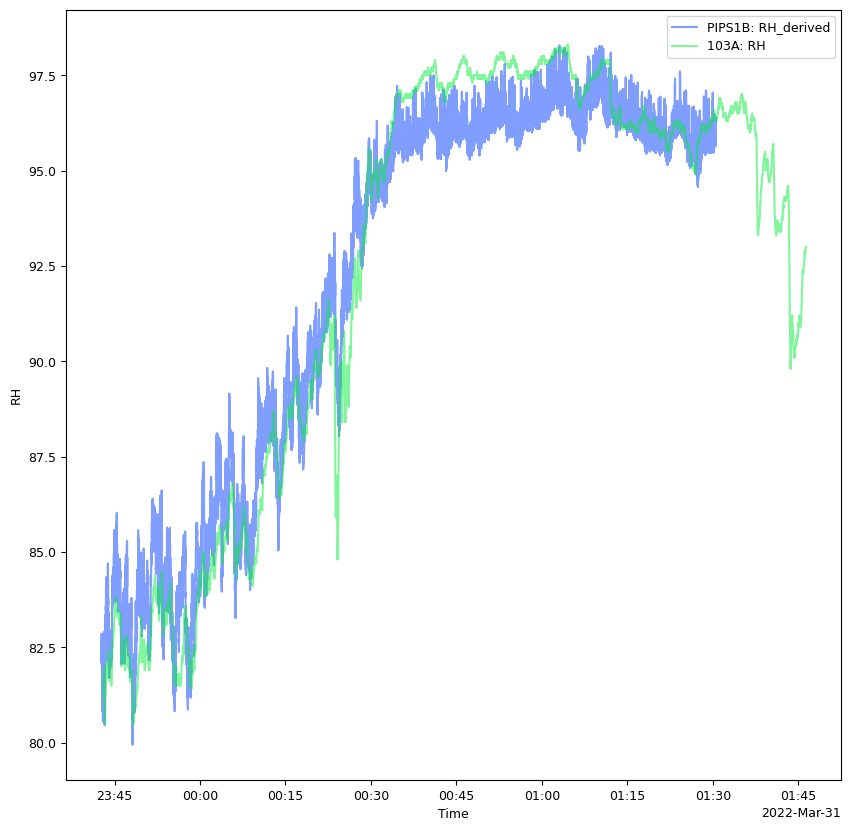

In [15]:
# Plot RH for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'RH_derived', 'RH', alpha=0.5)

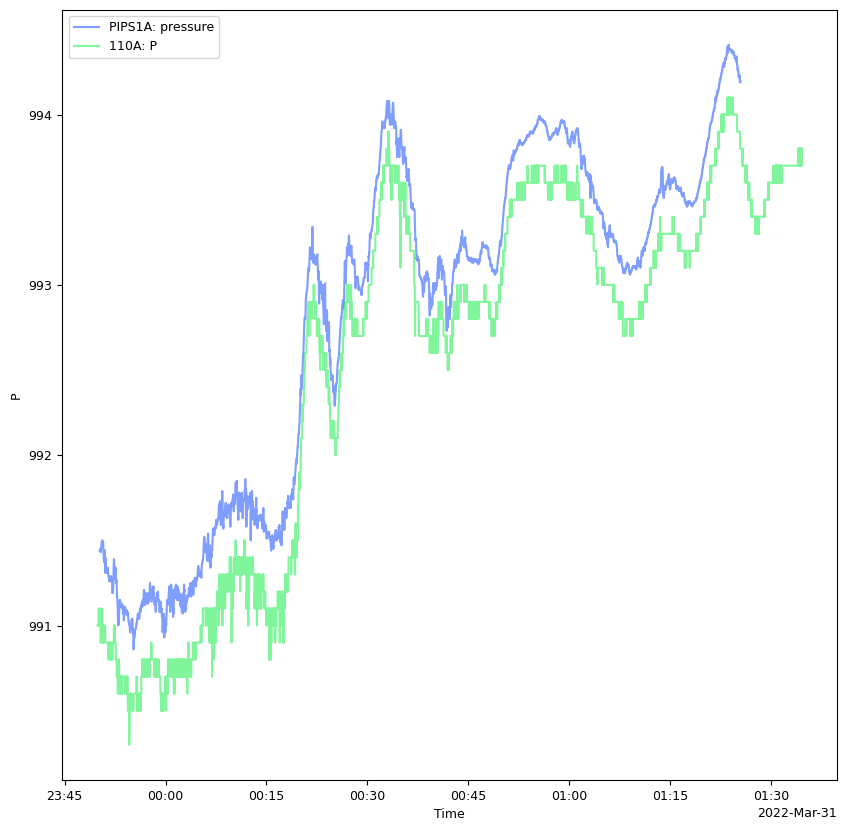

In [16]:
# Plot pressure for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'pressure', 'P', alpha=0.5)

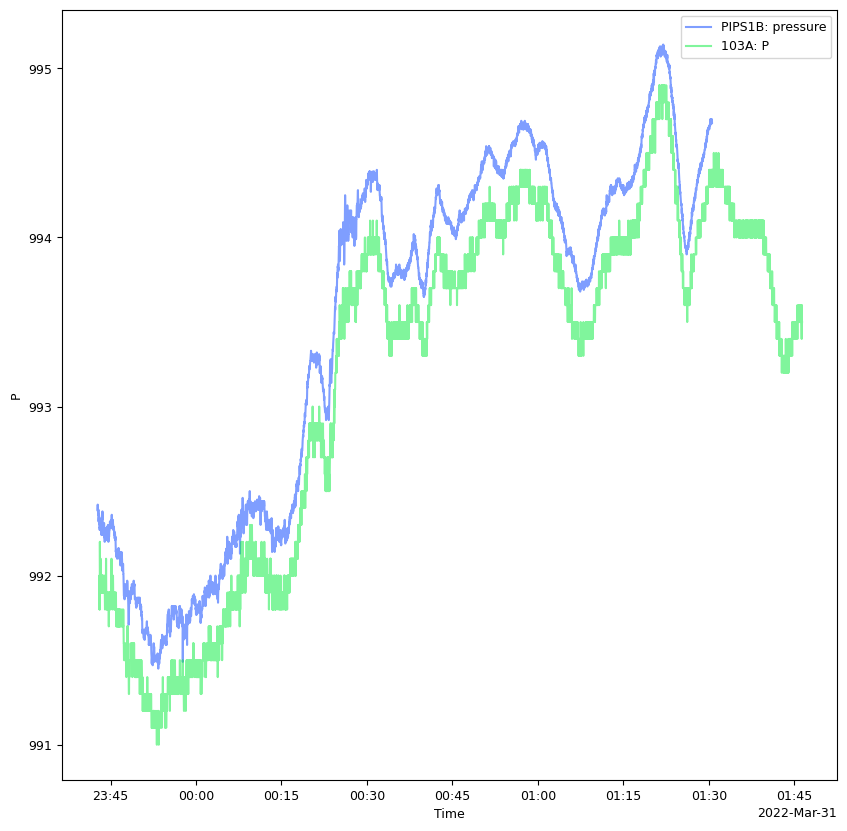

In [17]:
# Plot pressure for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'pressure', 'P', alpha=0.5)

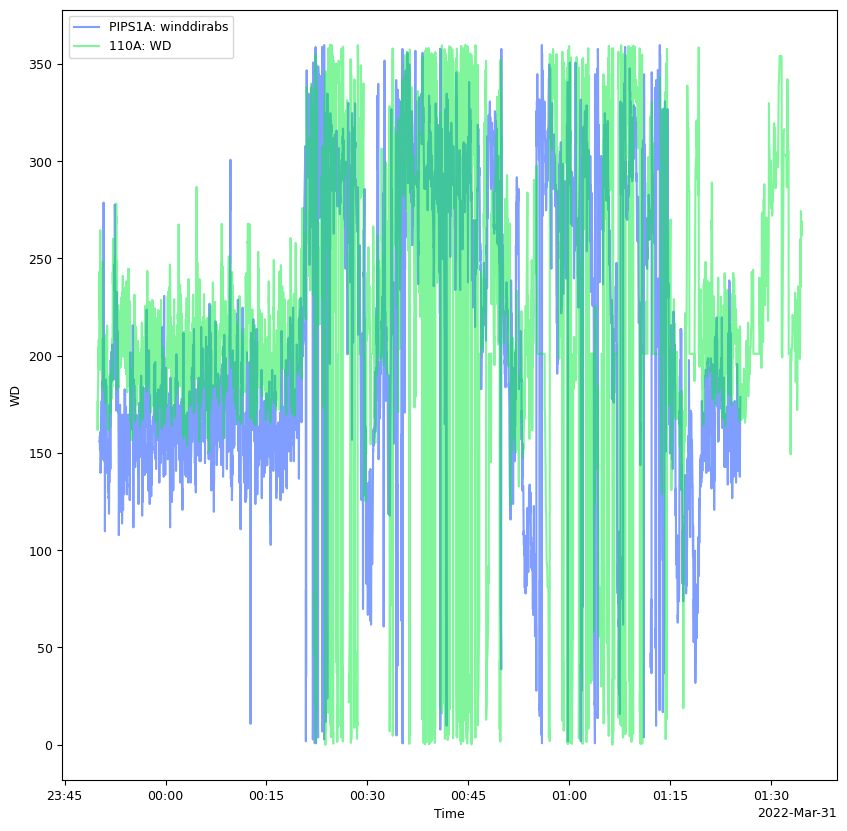

In [18]:
# Plot wind direction for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'winddirabs', 'WD', alpha=0.5)

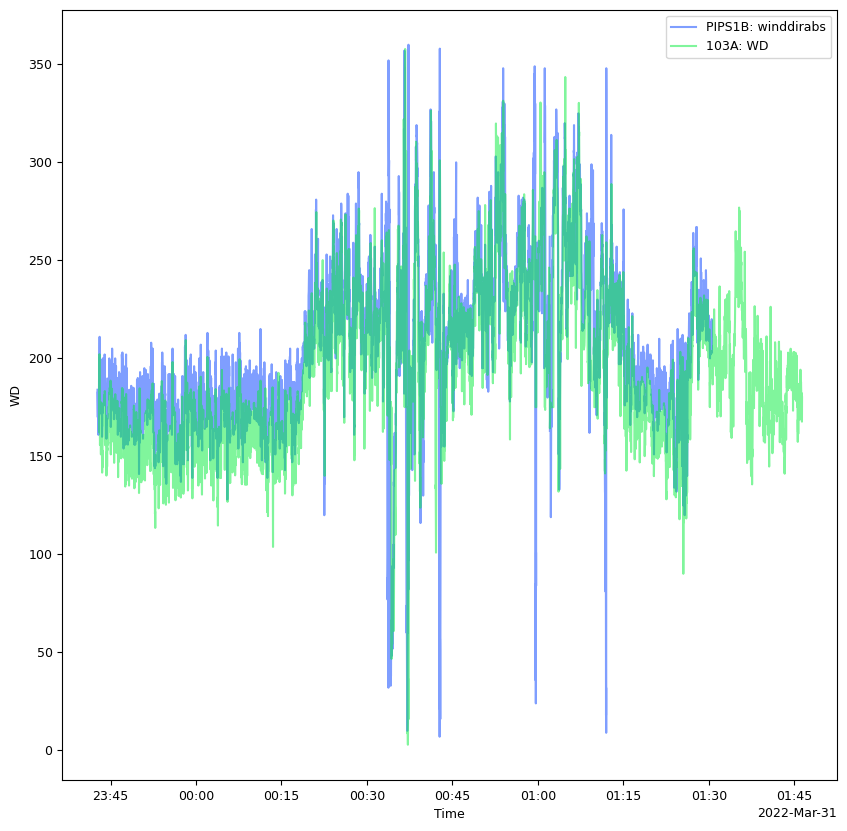

In [19]:
# Plot wind direction for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'winddirabs', 'WD', alpha=0.5)

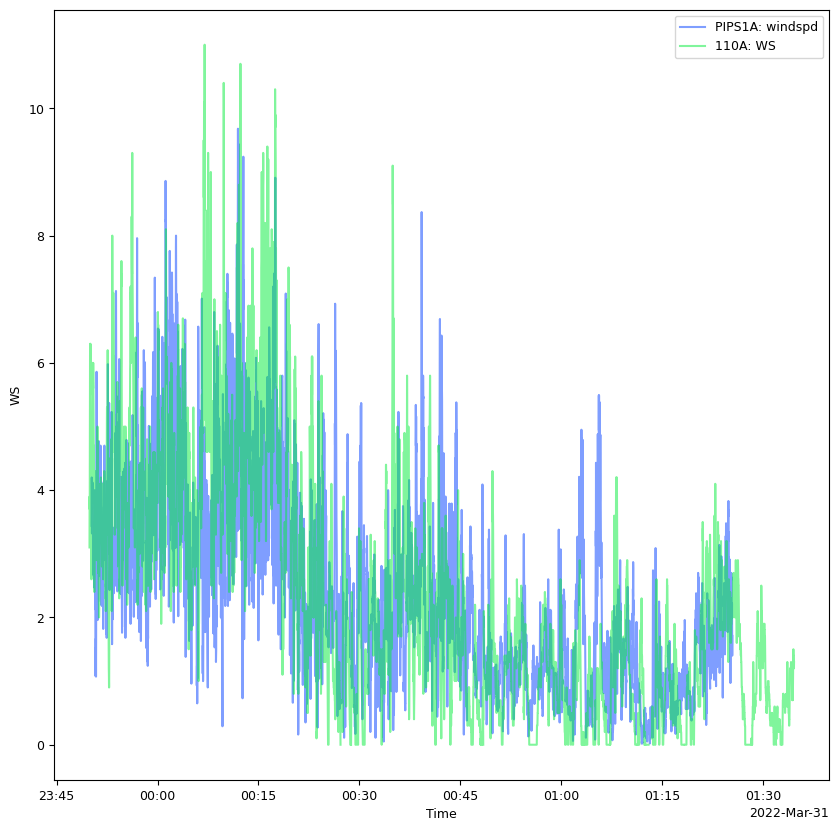

In [20]:
# Plot wind speed for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'windspd', 'WS', alpha=0.5)

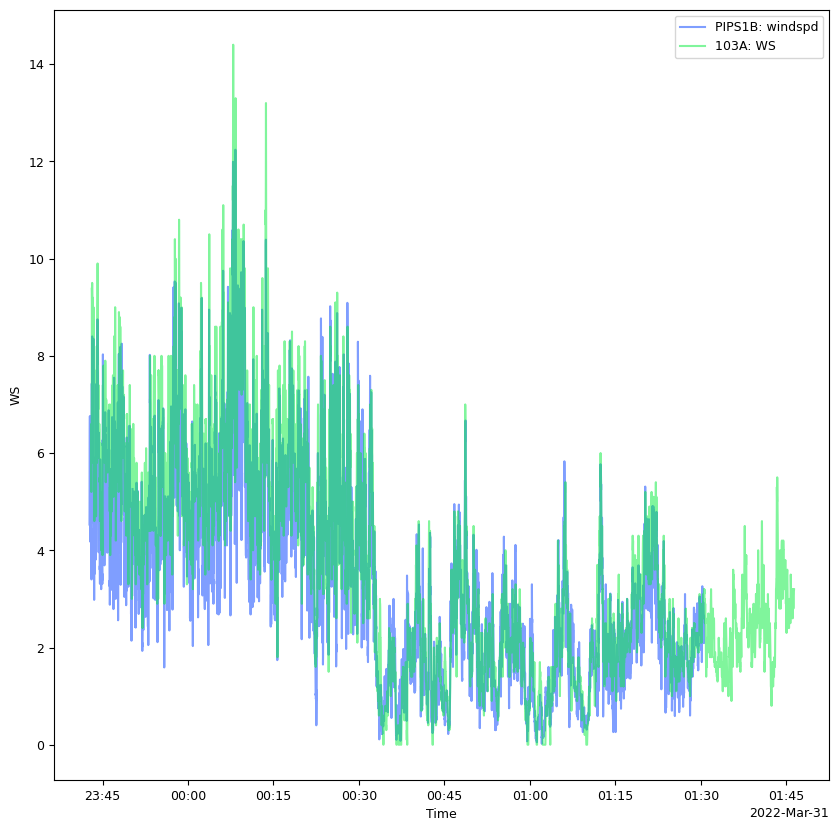

In [21]:
# Plot wind speed for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'windspd', 'WS', alpha=0.5)

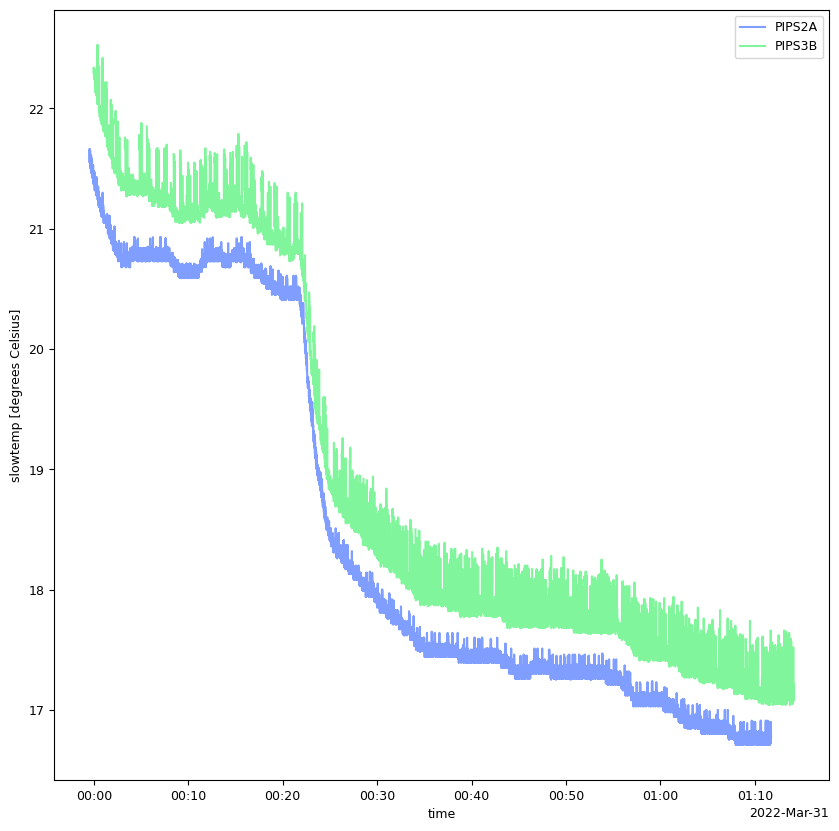

In [22]:
# Plot temperature for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'slowtemp', alpha=0.5)

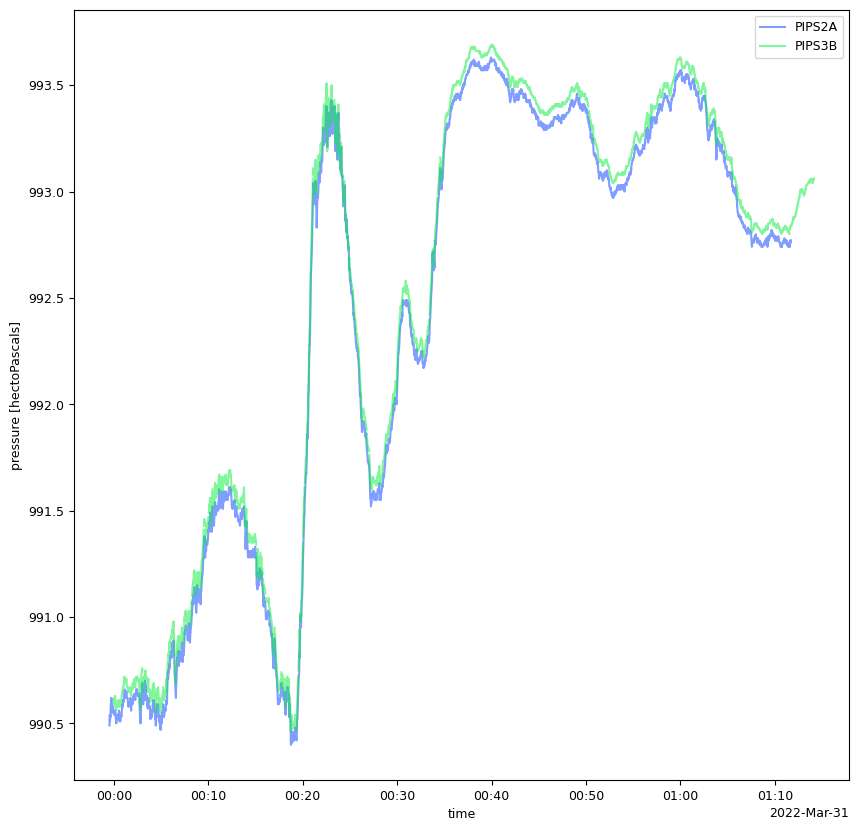

In [23]:
# Plot pressure for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'pressure', alpha=0.5)

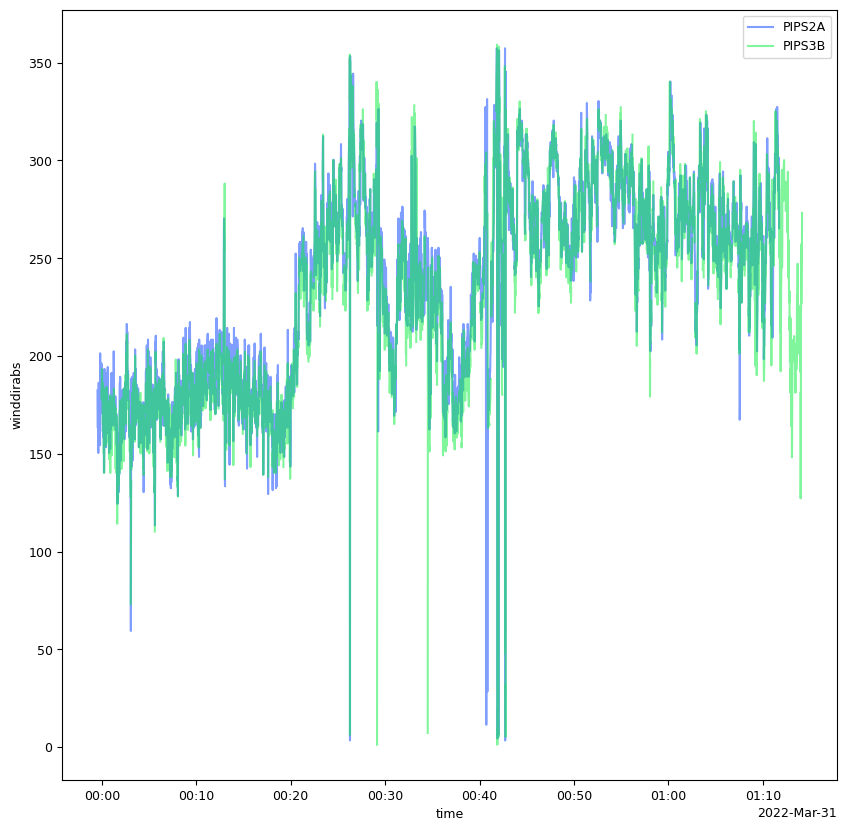

In [24]:
# Plot wind direction for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'winddirabs', alpha=0.5)

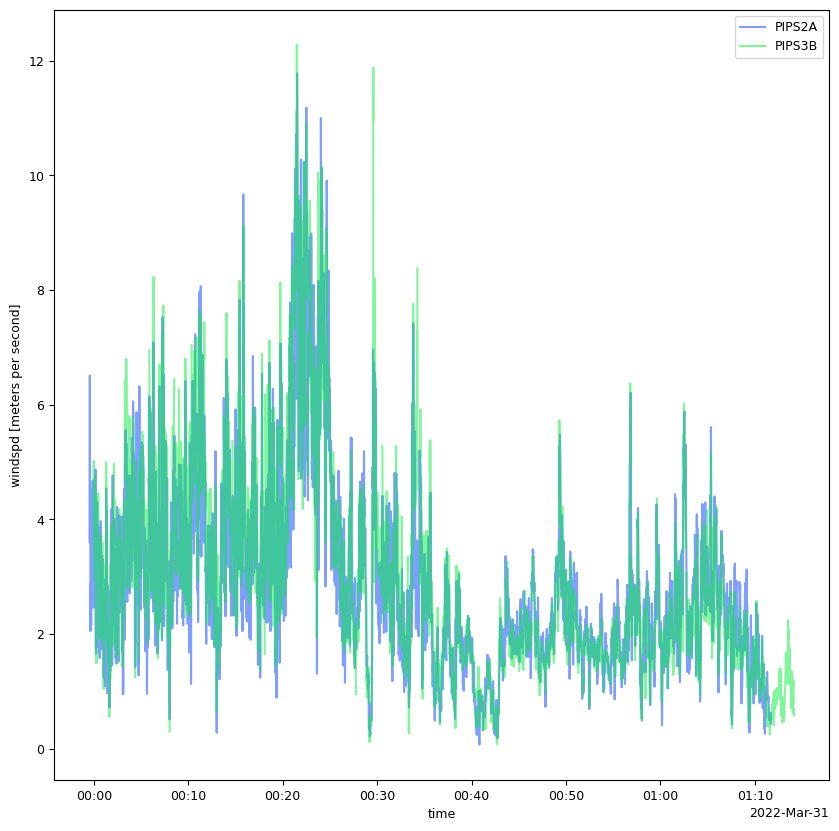

In [25]:
# Plot wind speed for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'windspd', alpha=0.5)

## In the following cells we will be doing the following:
1. Filter the noisy slowtemp and RH data for the PIPS (using same procedure as was done for the Sticknets)
2. Compute the gust front passage times for the Sticknet probes and realign data
3. Compute the gust front passage times for the PIPS (1-s data) and realign data
4. Use the closest Sticknet station to each of the PIPS to calculate biases in the various conventional data using the gust-front-relative data and correct the PIPS data accordingly

### Filter the noisy slowtemp and RH data for the PIPS (using same procedure as was done for the Sticknets)

In [26]:
import scipy.signal as signal

def filter_data(var_da, fs=1, order=28, cutoff_frequency=0.1, interp_na=True):
    # fs = 1  # Sampling frequency in Hz

    # # Design the 28th order Blackman-Harris filter
    # order = 28
    # cutoff_frequency = 0.1  # Cutoff frequency in Hz
    
    # Normalize the cutoff frequency with respect to Nyquist frequency
    normalized_cutoff = cutoff_frequency / (0.5 * fs)
    
    # Design the filter using firwin with a Blackman-Harris window
    b = signal.firwin(order + 1, normalized_cutoff, window='blackmanharris', pass_zero=True)

    if interp_na:
        var_da = var_da.interpolate_na(dim='time', keep_attrs=True)
    
    var_da_filt = signal.filtfilt(b, 1, var_da)

    return var_da_filt



In [27]:
# Apply the filter to the slow-temperature and relative humidity data

for name in PIPS_names:
    slowtemp = conv_ds_dict[name]['slowtemp']
    RH = conv_ds_dict[name]['RH']
    slowtemp_filt = filter_data(slowtemp, cutoff_frequency=0.1)
    RH_filt = filter_data(RH, cutoff_frequency=0.1)

    conv_ds_dict[name]['slowtemp'].data = slowtemp_filt
    conv_ds_dict[name]['slowtemp'].attrs['filtered'] = 'yes'
    conv_ds_dict[name]['RH'].data = RH_filt
    conv_ds_dict[name]['RH'].attrs['filtered'] = 'yes'
    
    # conv_ds_dict[name]['slowtemp_filt'] = signal.lfilter(b, 1, temperature)
    # conv_ds_dict[name]['RH_derived_filt'] = signal.lfilter(b, 1, RH)

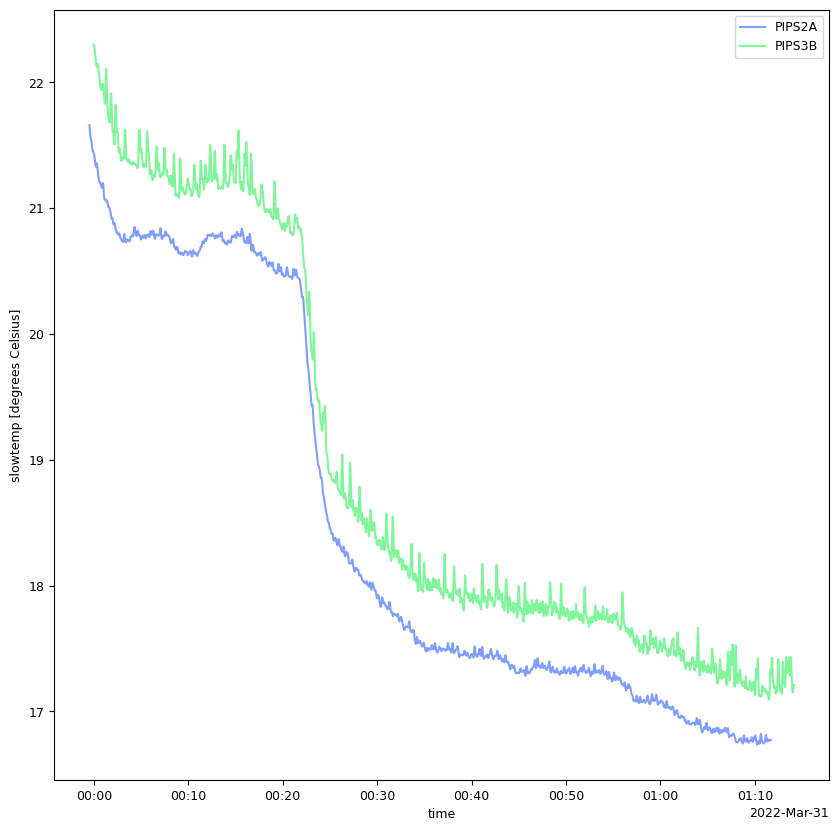

In [28]:
# Plot temperature for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'slowtemp', alpha=0.5)

### Compute the gust front passage times for the Sticknet probes

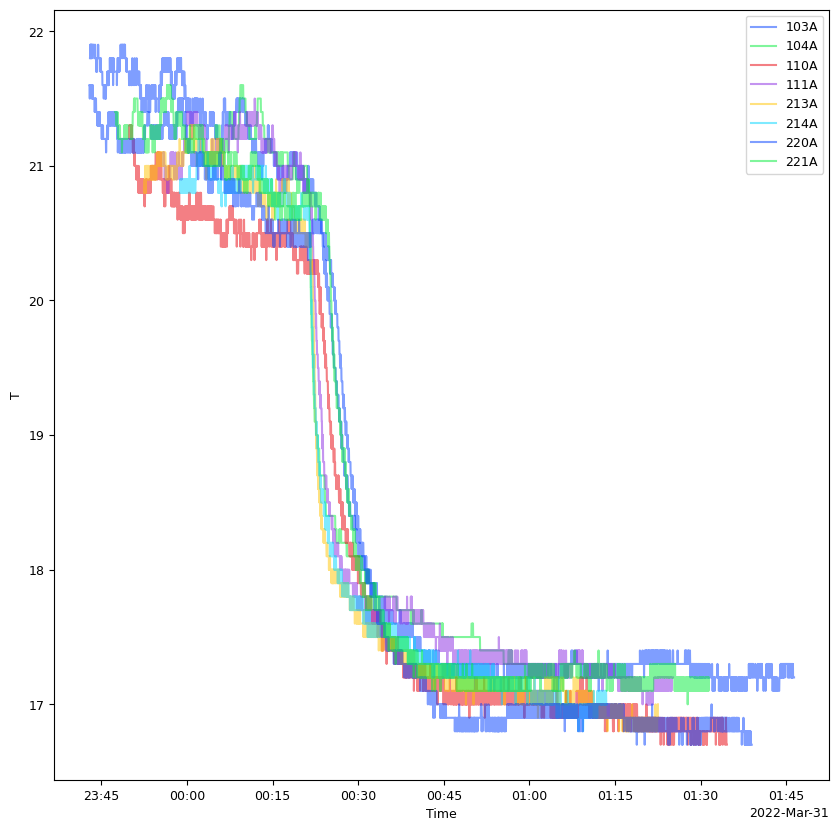

In [29]:
# Plot temperatures for sticknet probes
fig, ax = comp_plot(sticknet_fine_ids, sticknet_ds_dict, 'T', alpha=0.5, x='Time')

In [30]:
# Smooth the data a bit to remove short-range fluctuations
window_size = 120 # Corresponds to 2 min for the 1-s data
min_periods = 1

for name in sticknet_fine_ids:
    stick_ds = sticknet_ds_dict[name]
    T_smooth = stick_ds['T'].rolling(Time=window_size, center=True, min_periods=min_periods).mean()
    stick_ds['T_smooth'] = T_smooth

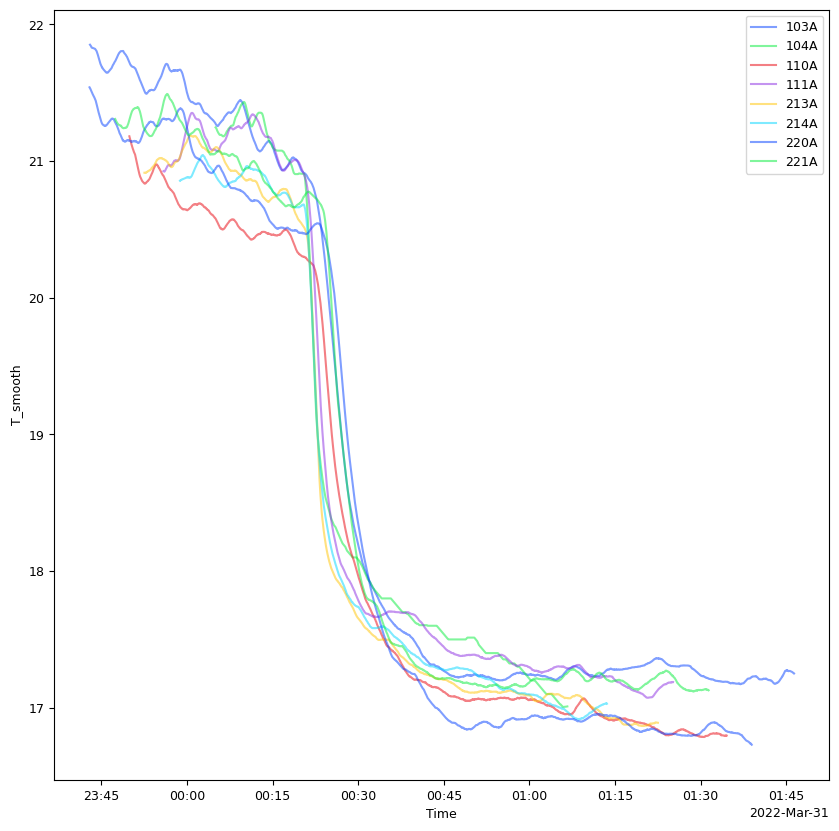

In [31]:
fig, ax = comp_plot(sticknet_fine_ids, sticknet_ds_dict, 'T_smooth', alpha=0.5, x='Time')

In [32]:
# Take the 1st-order difference of the smoothed temperature field
for name in sticknet_fine_ids:
    stick_ds = sticknet_ds_dict[name]
    diff_T = stick_ds['T_smooth'].diff(dim='Time', label='upper')
    # diff_T = diff_T.where(diff_T < -0.03, drop=True)
    stick_ds['diff_T'] = diff_T
    



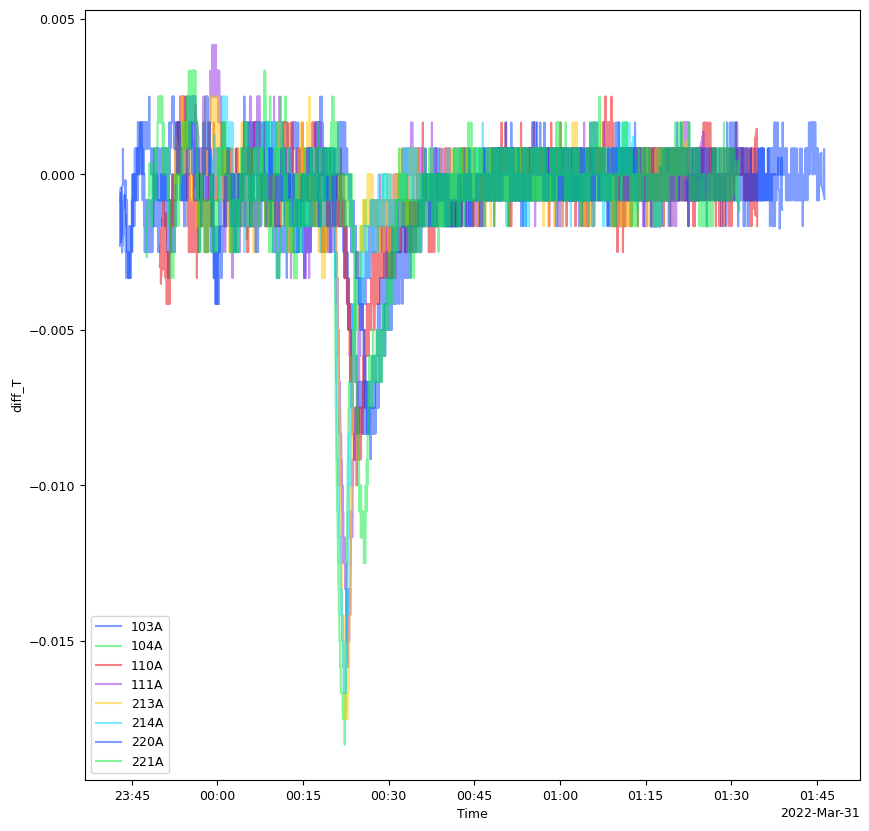

In [33]:
# Plot the temperature difference in adjacent times
fig, ax = comp_plot(sticknet_fine_ids, sticknet_ds_dict, 'diff_T', alpha=0.5, x='Time')

In [34]:
# From the above plot, we see we can take the time of the *minimum* signed temp difference (the time where the temp is dropping the fastest)
# as the reference time for the along line average
# EDIT: It looks like a better criterion is for when the temperature drop rate first exceeds a certain threshold -0.0075 deg C per s (for the smoothed data)
temp_drop_threshold = -0.0075

stick_gust_front_times = {}
for name in sticknet_fine_ids:
    # tindex = parsivel_ds_dict[PIPS_name]['diff_fasttemp'].argmin()
    diff_T = sticknet_ds_dict[name]['diff_T']
    tindex = xr.where(diff_T < temp_drop_threshold, True, False).argmax(dim='Time').item()
    gust_front_time = sticknet_ds_dict[name]['Time'].isel(Time=tindex).values
    stick_gust_front_times[name] = gust_front_time

stick_gust_front_times

{'103A': np.datetime64('2022-03-31T00:24:28.000000000'),
 '104A': np.datetime64('2022-03-31T00:20:43.000000000'),
 '110A': np.datetime64('2022-03-31T00:23:31.000000000'),
 '111A': np.datetime64('2022-03-31T00:21:20.000000000'),
 '213A': np.datetime64('2022-03-31T00:21:18.000000000'),
 '214A': np.datetime64('2022-03-31T00:20:57.000000000'),
 '220A': np.datetime64('2022-03-31T00:25:50.000000000'),
 '221A': np.datetime64('2022-03-31T00:24:25.000000000')}

In [35]:
# Create new time coordinate as time since gust front passage
new_sticknet_ds_dict = {}
for name, stick_ds in sticknet_ds_dict.items():
    gust_front_time = stick_gust_front_times[name]
    new_sticknet_ds_dict[name] = adjust_time_coordinate(stick_ds, gust_front_time, dim='Time')

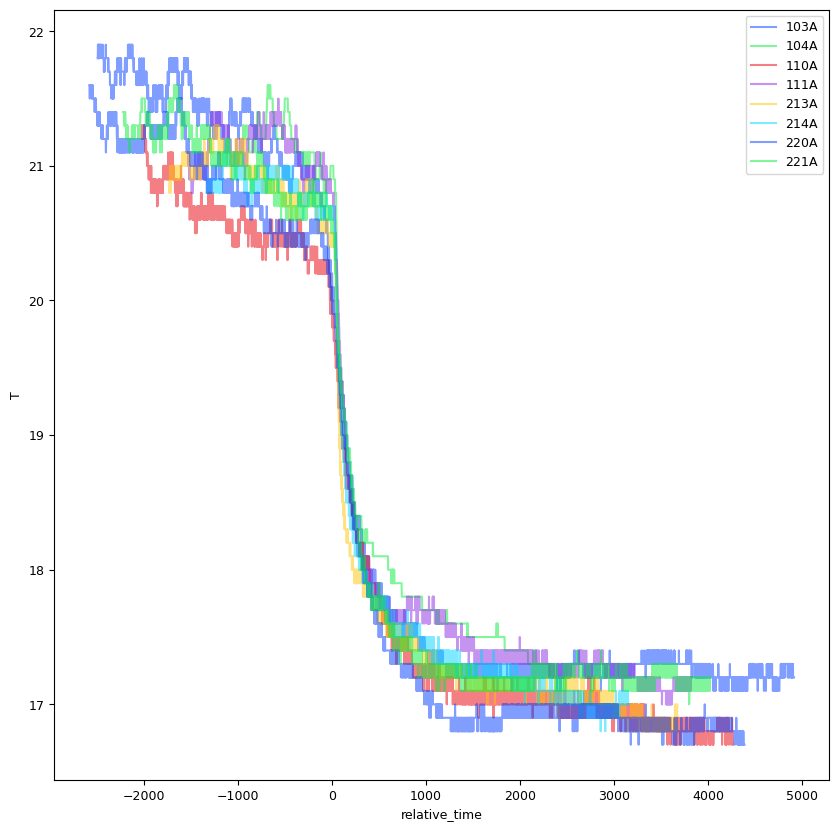

In [36]:
fig, ax = comp_plot(sticknet_fine_ids, new_sticknet_ds_dict, 'T', alpha=0.5, x='relative_time')

In [37]:
# Align datasets to common times
aligned_sticknet_datasets = xr.align(*new_sticknet_ds_dict.values(), join='inner')

# Combine datasets into a new Dataset with a new dimension 'PIPS'
# combined_sticknet_ds = xr.concat(aligned_sticknet_datasets, dim='probe_name')
# combined_sticknet_ds['probe_name'] = list(sticknet_ds_dict.keys())

# Convert TimeDelta objects to seconds for plotting
# combined_parsivel_ds = combined_parsivel_ds.assign_coords(
#     seconds_since_gust_front=combined_parsivel_ds['relative_time'].dt.total_seconds()
# )


### Compute the gust front passage times for the PIPS (1-s data)

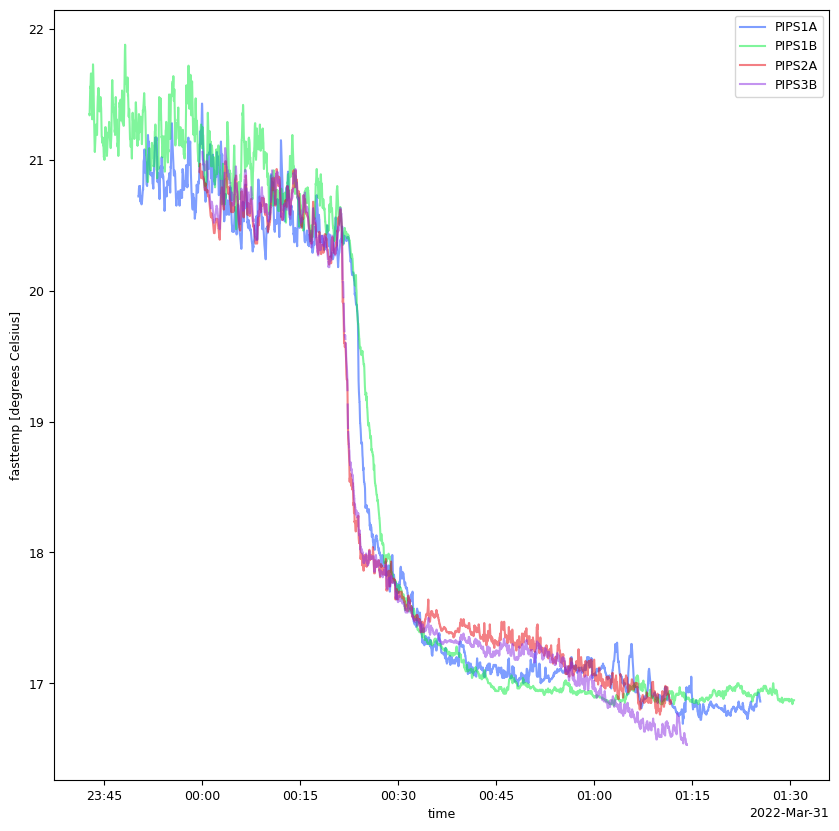

In [38]:
# Plot temperatures
fig, ax = comp_plot(PIPS_names, conv_ds_dict, 'fasttemp', alpha=0.5)

In [39]:
# Smooth the data a bit to remove short-range fluctuations
window_size = 120 # Corresponds to 2 min for the 1-s data
min_periods = 1

for PIPS_name in PIPS_names:
    conv_ds = conv_ds_dict[PIPS_name]
    fasttemp_smooth = conv_ds['fasttemp'].rolling(time=window_size, center=True, min_periods=min_periods).mean()
    conv_ds['fasttemp_smooth'] = fasttemp_smooth

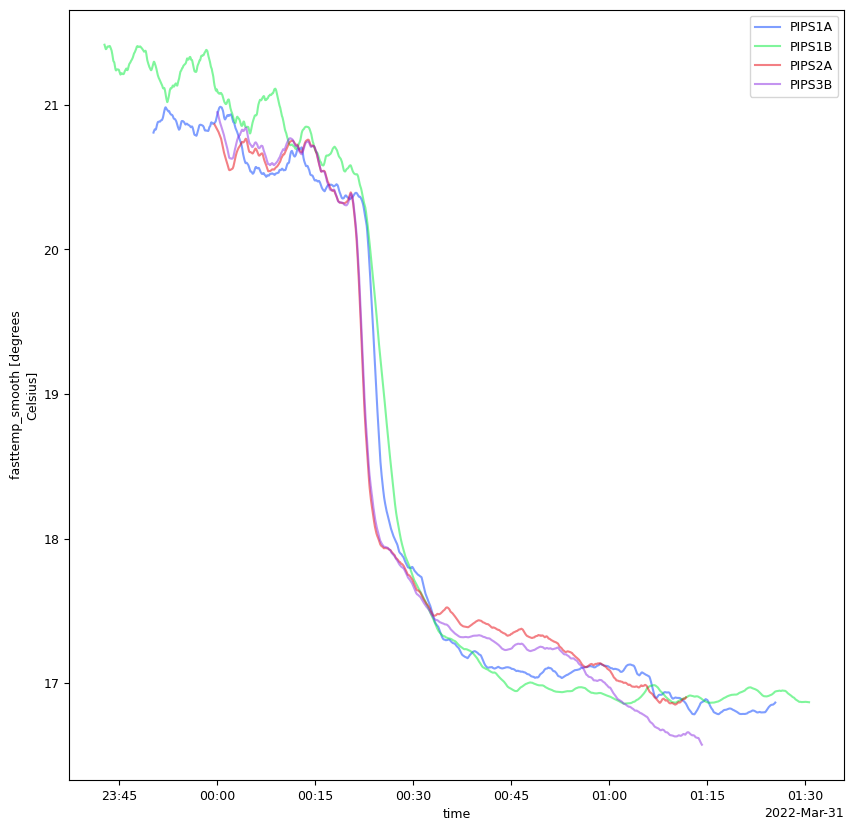

In [40]:
fig, ax = comp_plot(PIPS_names, conv_ds_dict, 'fasttemp_smooth', alpha=0.5)

In [41]:
# Take the 1st-order difference of the smoothed temperature field
for PIPS_name in PIPS_names:
    conv_ds = conv_ds_dict[PIPS_name]
    diff_T = conv_ds['fasttemp_smooth'].diff(dim='time', label='upper')
    # diff_T = diff_T.where(diff_T < -0.03, drop=True)
    conv_ds['diff_fasttemp'] = diff_T
    

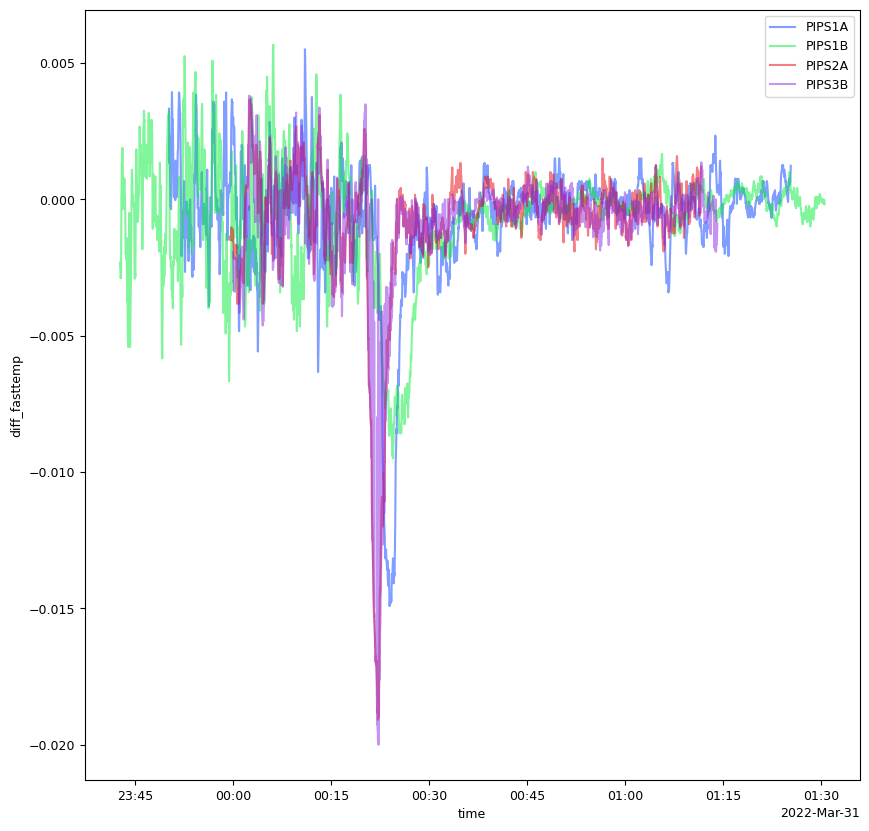

In [42]:
# Plot the temperature difference in adjacent times
fig, ax = comp_plot(PIPS_names, conv_ds_dict, 'diff_fasttemp', alpha=0.5)

In [43]:
# From the above plot, we see we can take the time of the *minimum* signed temp difference (the time where the temp is dropping the fastest)
# as the reference time for the along line average
# EDIT: It looks like a better criterion is for when the temperature drop rate first exceeds -0.0075 deg C per 1 s (for the smoothed data)
temp_drop_threshold = -0.0075

PIPS_gust_front_times = {}
for PIPS_name in PIPS_names:
    # tindex = parsivel_ds_dict[PIPS_name]['diff_fasttemp'].argmin()
    diff_T = conv_ds_dict[PIPS_name]['diff_fasttemp']
    tindex = xr.where(diff_T < temp_drop_threshold, True, False).argmax(dim='time').item()
    gust_front_time = conv_ds_dict[PIPS_name]['time'].isel(time=tindex).values
    # For the collocated probes, we assume that the gust front passes them at the exact same time, even if the above calculation is 
    # a bit different from that. It really shouldn't matter too much, but we'll use the collocated sticknet time of passage
    if PIPS_name == 'PIPS1A':
        PIPS_gust_front_times[PIPS_name] = stick_gust_front_times['110A']
    elif PIPS_name == 'PIPS1B':
        PIPS_gust_front_times[PIPS_name] = stick_gust_front_times['103A']
    else:
        PIPS_gust_front_times[PIPS_name] = gust_front_time

PIPS_gust_front_times['PIPS3B'] = PIPS_gust_front_times['PIPS2A']

PIPS_gust_front_times

{'PIPS1A': np.datetime64('2022-03-31T00:23:31.000000000'),
 'PIPS1B': np.datetime64('2022-03-31T00:24:28.000000000'),
 'PIPS2A': np.datetime64('2022-03-31T00:21:01.000000000'),
 'PIPS3B': np.datetime64('2022-03-31T00:21:01.000000000')}

In [44]:
for PIPS_name in PIPS_names:
    # I hate these datetime to datetime64 and vice-versa shenanigans :(
    time_dt = pd.to_datetime(str(PIPS_gust_front_times[PIPS_name])) 
    timestring = time_dt.strftime("%Y%m%d%H%M%S")
    print(f"{PIPS_name}: {timestring}")

PIPS1A: 20220331002331
PIPS1B: 20220331002428
PIPS2A: 20220331002101
PIPS3B: 20220331002101


In [45]:
# Create new time coordinate as time since gust front passage
new_conv_ds_dict = {}
for PIPS_name, conv_ds in conv_ds_dict.items():
    gust_front_time = PIPS_gust_front_times[PIPS_name]
    new_conv_ds_dict[PIPS_name] = adjust_time_coordinate(conv_ds, gust_front_time)

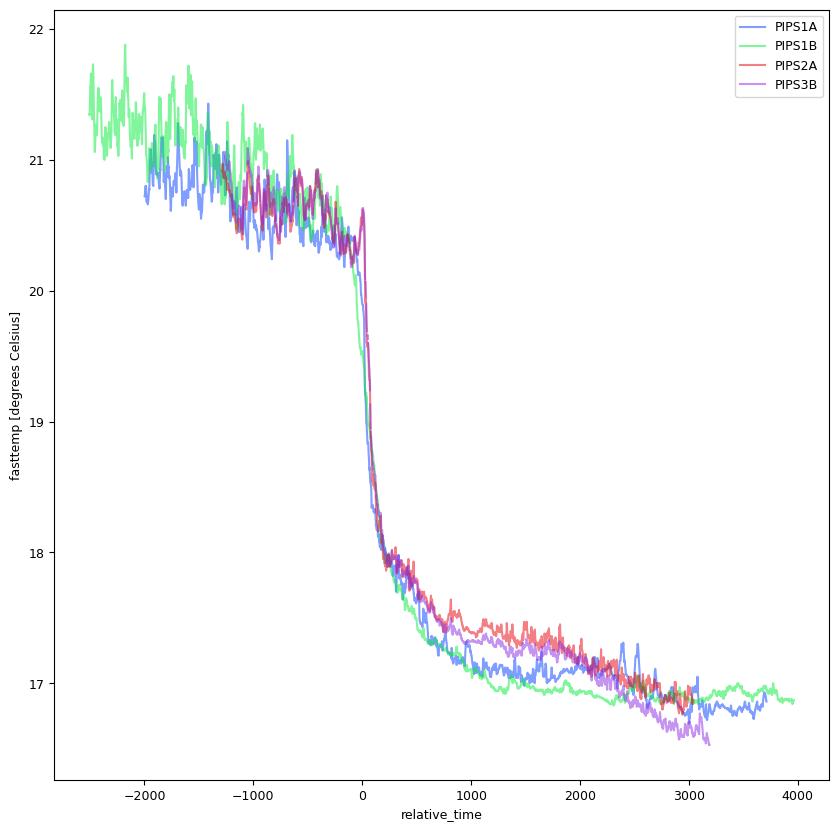

In [46]:
fig, ax = comp_plot(PIPS_names, new_conv_ds_dict, 'fasttemp', alpha=0.5, x='relative_time')

In [47]:
# Align datasets to common times
aligned_PIPS_datasets = xr.align(*new_conv_ds_dict.values(), join='inner')

# Combine datasets into a new Dataset with a new dimension 'PIPS'
# combined_PIPS_ds = xr.concat(aligned_PIPS_datasets, dim='probe_name')
# combined_PIPS_ds['probe_name'] = list(conv_ds_dict.keys())

# Convert TimeDelta objects to seconds for plotting
# combined_parsivel_ds = combined_parsivel_ds.assign_coords(
#     seconds_since_gust_front=combined_parsivel_ds['relative_time'].dt.total_seconds()
# )

### Use the closest Sticknet station to each of the PIPS to calculate biases in the various conventional data using the gust-front-relative data and correct the PIPS data accordingly

In [48]:
def bias_correct_vars(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, vars):
    for var_group in vars:
        diff_var = aligned_datasets_dict[PIPS_name][var_group[0]] - aligned_datasets_dict[stick_name][var_group[1]]
        mean_diff_var = diff_var.mean().values
        # Note that we also correct the *original* PIPS dataset variables, *not* just the new aligned ones, 
        # since those cut off data on either side. We want to save back to the original files with the corrected variables.

        if 'bias_subtracted' not in conv_ds_dict[PIPS_name][f'{var_group[0]}'].attrs:
            conv_ds_dict[PIPS_name][f'{var_group[0]}'] = conv_ds_dict[PIPS_name][var_group[0]] - mean_diff_var
            # Add the value subtracted to the attributes so we know that we modified it
            conv_ds_dict[PIPS_name][f'{var_group[0]}'].attrs['bias_subtracted'] = mean_diff_var
            aligned_datasets_dict[PIPS_name][f'{var_group[0]}'] = aligned_datasets_dict[PIPS_name][var_group[0]] - mean_diff_var
            # Add the value subtracted to the attributes so we know that we modified it
            aligned_datasets_dict[PIPS_name][f'{var_group[0]}'].attrs['bias_subtracted'] = mean_diff_var
        else:
            print(f"Already bias-corrected {var_group[0]} for {PIPS_name}, silly!")
    
    return aligned_datasets_dict, conv_ds_dict

def bias_correct_wind_dir(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, winddir_name_PIPS, winddir_name_stick):
    # Wind direction

    # # First compute the u and v wind components
    # u_PIPS = aligned_datasets_dict['PIPS1A']['windspd'] * np.cos(np.deg2rad(-aligned_datasets_dict['PIPS1A']['winddirabs'] + 270.))
    # v_PIPS = aligned_datasets_dict['PIPS1A']['windspd'] * np.sin(np.deg2rad(-aligned_datasets_dict['PIPS1A']['winddirabs'] + 270.))
    
    # u_stick = aligned_datasets_dict['110A']['WS'] * np.cos(np.deg2rad(-aligned_datasets_dict['110A']['WD'] + 270.))
    # v_stick = aligned_datasets_dict['110A']['WS'] * np.sin(np.deg2rad(-aligned_datasets_dict['110A']['WD'] + 270.))
    
    # diff_u = u_PIPS - u_stick
    # diff_v = v_PIPS - v_stick
    
    diff_winddir = aligned_datasets_dict[PIPS_name][winddir_name_PIPS] - aligned_datasets_dict[stick_name][winddir_name_stick]
    diff_winddir = xr.where(diff_winddir > 180., diff_winddir - 360., diff_winddir)
    diff_winddir = xr.where(diff_winddir < -180., diff_winddir + 360., diff_winddir)
    mean_diff_winddir = diff_winddir.mean().values

    if 'bias_subtracted' not in conv_ds_dict[PIPS_name][winddir_name_PIPS].attrs:
        # Note that we also correct the *original* PIPS dataset variables, *not* just the new aligned ones, 
        # since those cut off data on either side. We want to save back to the original files with the corrected variables.
        conv_ds_dict[PIPS_name][winddir_name_PIPS] = (conv_ds_dict[PIPS_name][winddir_name_PIPS] - mean_diff_winddir) % 360
        # Add the value subtracted to the attributes so we know that we modified it
        conv_ds_dict[PIPS_name][winddir_name_PIPS].attrs['bias_subtracted'] = mean_diff_winddir
        
        aligned_datasets_dict[PIPS_name][winddir_name_PIPS] = (aligned_datasets_dict[PIPS_name][winddir_name_PIPS] - mean_diff_winddir) % 360
        # Add the value subtracted to the attributes so we know that we modified it
        aligned_datasets_dict[PIPS_name][winddir_name_PIPS].attrs['bias_subtracted'] = mean_diff_winddir
    else:
        print(f"Already bias-corrected {winddir_name_PIPS} for {PIPS_name}, silly!")

    return aligned_datasets_dict, conv_ds_dict

In [49]:
# First align all the PIPS and Sticknet probes by gust-front-relative time
all_probe_names = list(sticknet_ds_dict.keys()) + list(conv_ds_dict.keys())
all_datasets = list(new_sticknet_ds_dict.values()) + list(new_conv_ds_dict.values())
aligned_datasets = xr.align(*all_datasets, join='inner')
aligned_datasets_dict = {probe_name: ds for probe_name, ds in zip(all_probe_names, aligned_datasets)}

In [50]:
aligned_datasets_dict

{'103A': <xarray.Dataset> Size: 266kB
 Dimensions:        (relative_time: 3699)
 Coordinates:
   * relative_time  (relative_time) float64 30kB -943.0 -942.0 ... 2.755e+03
     Time           (relative_time) datetime64[ns] 30kB 2022-03-31T00:08:45 .....
 Data variables:
     T              (relative_time) float64 30kB 21.5 21.5 21.5 ... 17.2 17.2
     RH             (relative_time) float64 30kB 84.5 84.5 84.5 ... 97.7 97.7
     P              (relative_time) float64 30kB 992.1 992.1 ... 993.6 993.7
     WS             (relative_time) float64 30kB 8.0 9.8 10.5 8.7 ... 1.0 0.8 1.0
     WD             (relative_time) float64 30kB 178.5 175.6 ... 183.5 180.7
     T_smooth       (relative_time) float64 30kB 21.42 21.42 ... 17.24 17.24
     diff_T         (relative_time) float64 30kB 0.001667 ... -0.0008333
 Attributes:
     probe_name:     103A
     location:       (33.714987, -88.450477, 72.4)
     Array_Type:     Fine
     starting_time:  20220330234300
     ending_time:    20220331014621,

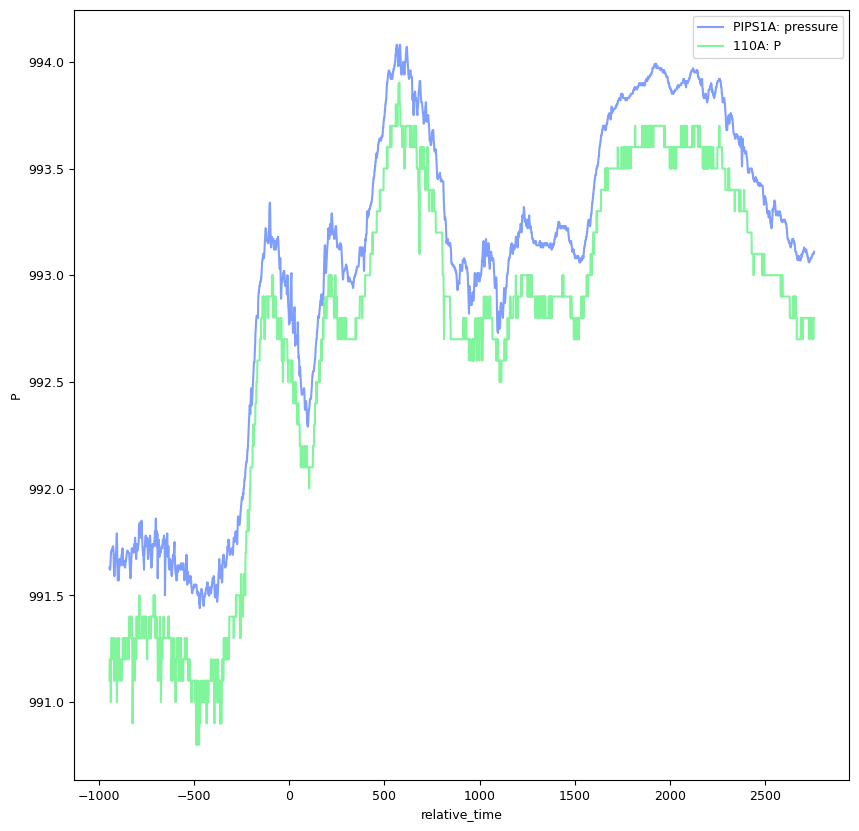

In [51]:
# Sanity check!
fig, ax = comp_var_ds_plot(aligned_datasets_dict['PIPS1A'], aligned_datasets_dict['110A'], 'pressure', 'P', alpha=0.5)

In [52]:
# Define variables to correct (except for wind direction, which is done a bit differently, and wind speed, which arguably should be a bit
# lower for the PIPS since they are shorter...)
vars = [['fasttemp', 'T'], ['slowtemp', 'T'], ['RH', 'RH'], ['pressure', 'P']]

winddir_name_PIPS = 'winddirabs'
winddir_name_stick = 'WD'

In [53]:
# PIPS1A and 110A
PIPS_name = 'PIPS1A'
stick_name = '110A'

aligned_datasets_dict, conv_ds_dict = bias_correct_vars(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, vars)
aligned_datasets_dict, conv_ds_dict = bias_correct_wind_dir(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, winddir_name_PIPS, 
                                                            winddir_name_stick)

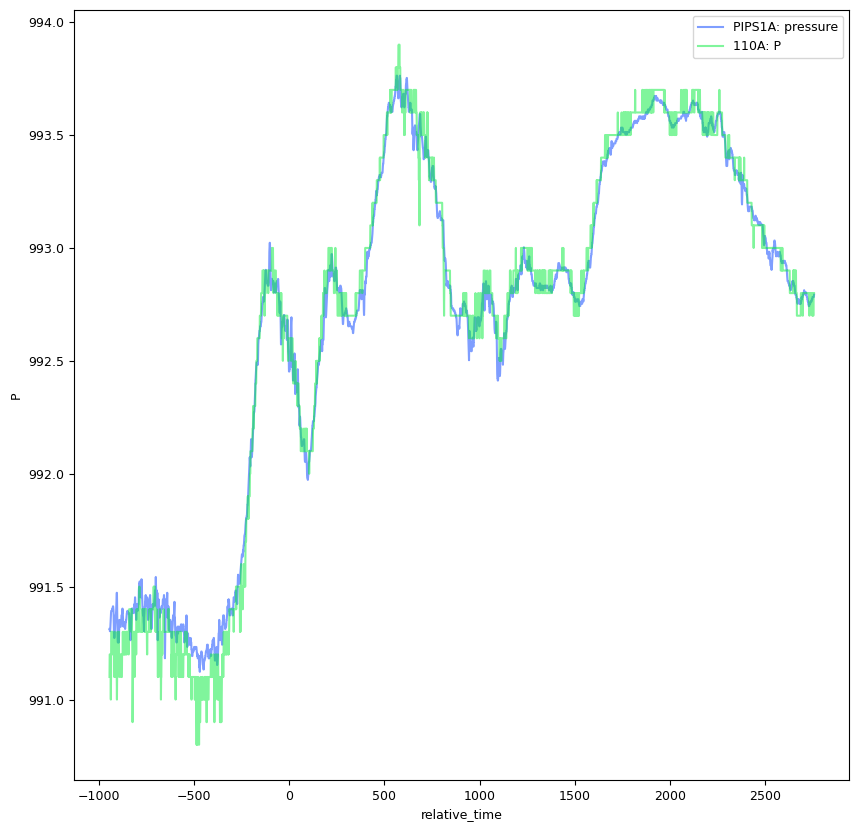

In [54]:
# Sanity check!
fig, ax = comp_var_ds_plot(aligned_datasets_dict['PIPS1A'], aligned_datasets_dict['110A'], 'pressure', 'P', alpha=0.5)


In [55]:
print(aligned_datasets_dict['PIPS1A']['fasttemp'].attrs)

{'bias_subtracted': array(-0.04603677)}


In [56]:
# PIPS1B and 103A
PIPS_name = 'PIPS1B'
stick_name = '103A'

aligned_datasets_dict, conv_ds_dict = bias_correct_vars(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, vars)
aligned_datasets_dict, conv_ds_dict = bias_correct_wind_dir(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, winddir_name_PIPS, 
                                                            winddir_name_stick)

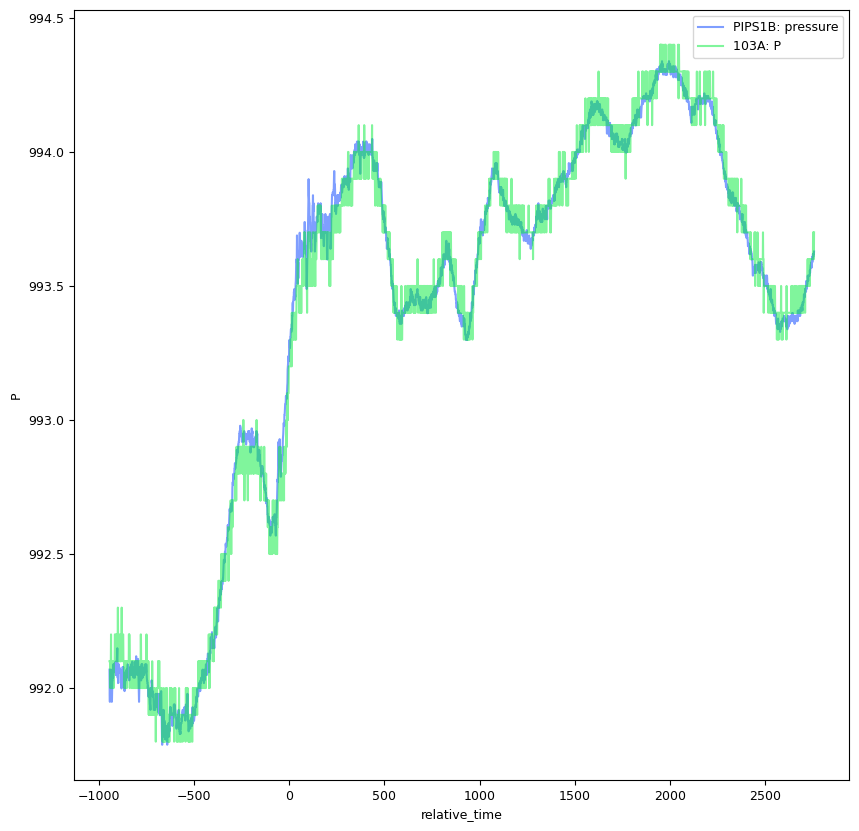

In [57]:
# Sanity check!
fig, ax = comp_var_ds_plot(aligned_datasets_dict[PIPS_name], aligned_datasets_dict[stick_name], 'pressure', 'P', alpha=0.5)

In [58]:
print(aligned_datasets_dict['PIPS1B']['fasttemp'].attrs)


{'bias_subtracted': array(-0.36657205)}


In [59]:
# PIPS2A and 104A
PIPS_name = 'PIPS2A'
stick_name = '104A'

aligned_datasets_dict, conv_ds_dict = bias_correct_vars(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, vars)
aligned_datasets_dict, conv_ds_dict = bias_correct_wind_dir(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, winddir_name_PIPS, 
                                                            winddir_name_stick)

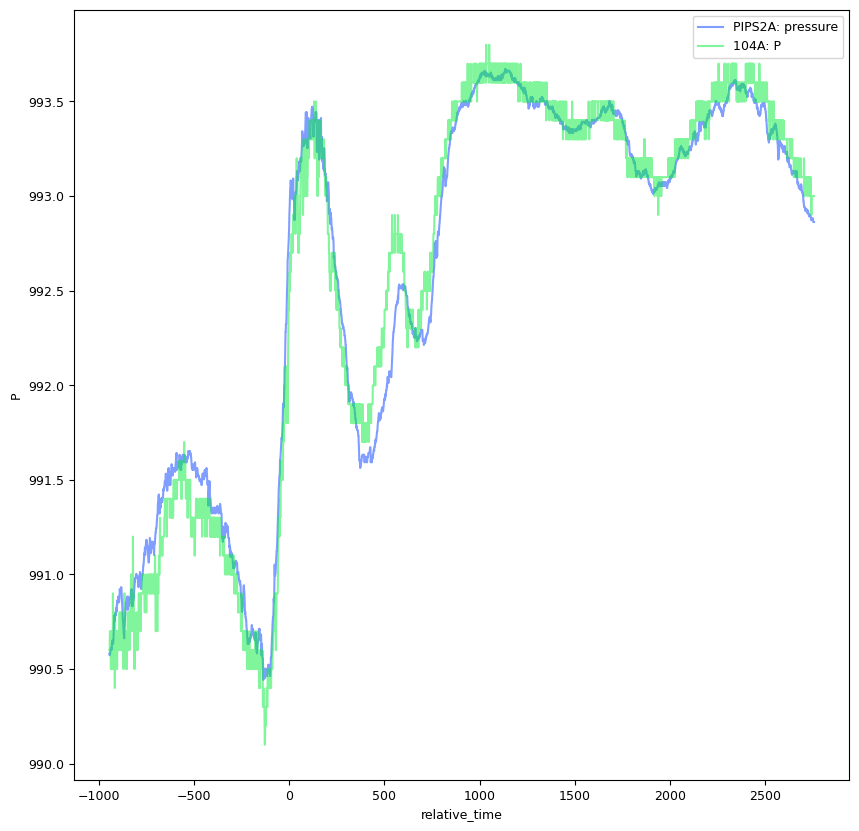

In [60]:
# Sanity check!
fig, ax = comp_var_ds_plot(aligned_datasets_dict[PIPS_name], aligned_datasets_dict[stick_name], 'pressure', 'P', alpha=0.5)

In [61]:
# PIPS3B and 104A

PIPS_name = 'PIPS3B'
stick_name = '104A'

aligned_datasets_dict, conv_ds_dict = bias_correct_vars(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, vars)
aligned_datasets_dict, conv_ds_dict = bias_correct_wind_dir(aligned_datasets_dict, conv_ds_dict, PIPS_name, stick_name, winddir_name_PIPS, 
                                                            winddir_name_stick)

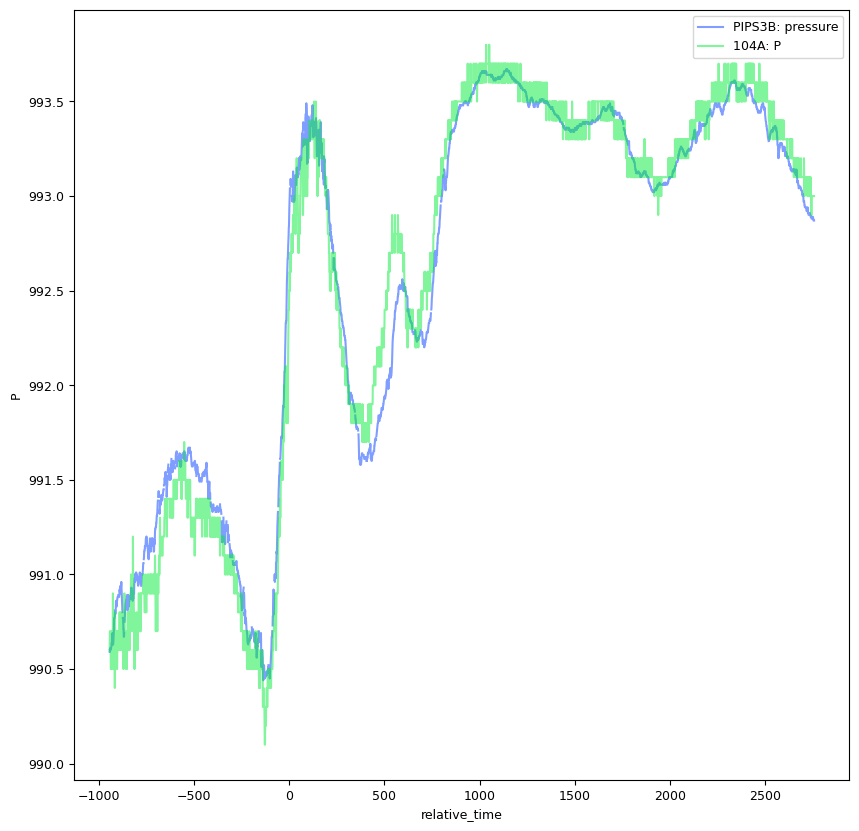

In [62]:
# Sanity check!
fig, ax = comp_var_ds_plot(aligned_datasets_dict[PIPS_name], aligned_datasets_dict[stick_name], 'pressure', 'P', alpha=0.5)

In [63]:
# Now, we need to recompute the dewpoint and RH_derived using the bias-corrected quantites from above
# Do this just for the original conventional PIPS datasets

for PIPS_name in PIPS_names:
    pressure = conv_ds_dict[PIPS_name]['pressure']
    slowtemp = conv_ds_dict[PIPS_name]['slowtemp']
    fasttemp = conv_ds_dict[PIPS_name]['fasttemp']
    RH = conv_ds_dict[PIPS_name]['RH']
    dewpoint = thermo.calTdfromRH(pressure * 100., slowtemp + 273.15, RH / 100.) - 273.15
#     dewpoint.sel(time=slice(time_start, time_stop)).plot(ax=ax, label=f'{PIPS_name}_dewpoint', 
#                                                          ls='None', marker='o', ms=1., alpha=0.5)
    RH_derived = thermo.calRH(pressure * 100., fasttemp + 273.15, dewpoint + 273.15) * 100.
    
    conv_ds_dict[PIPS_name]['dewpoint'].data = dewpoint
    conv_ds_dict[PIPS_name]['RH_derived'].data = RH_derived

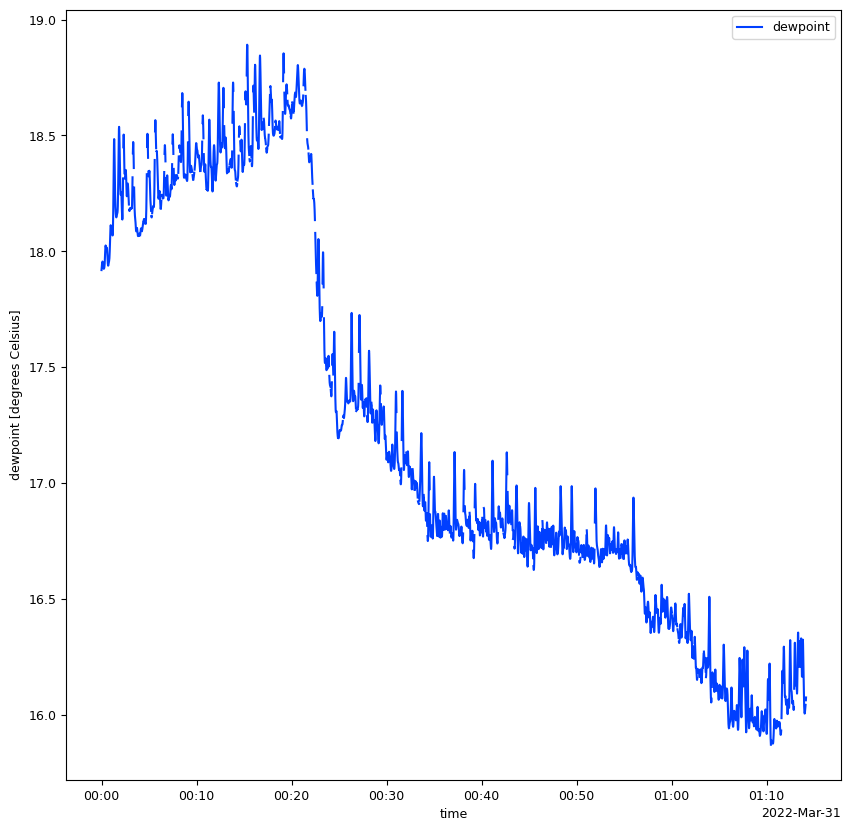

In [64]:
# Sanity check!

PIPS_name = 'PIPS3B'

fig, ax = plt.subplots(figsize=(10, 10))

conv_ds_dict[PIPS_name]['dewpoint'].plot(ax=ax, label='dewpoint')
ax.legend(loc='best')


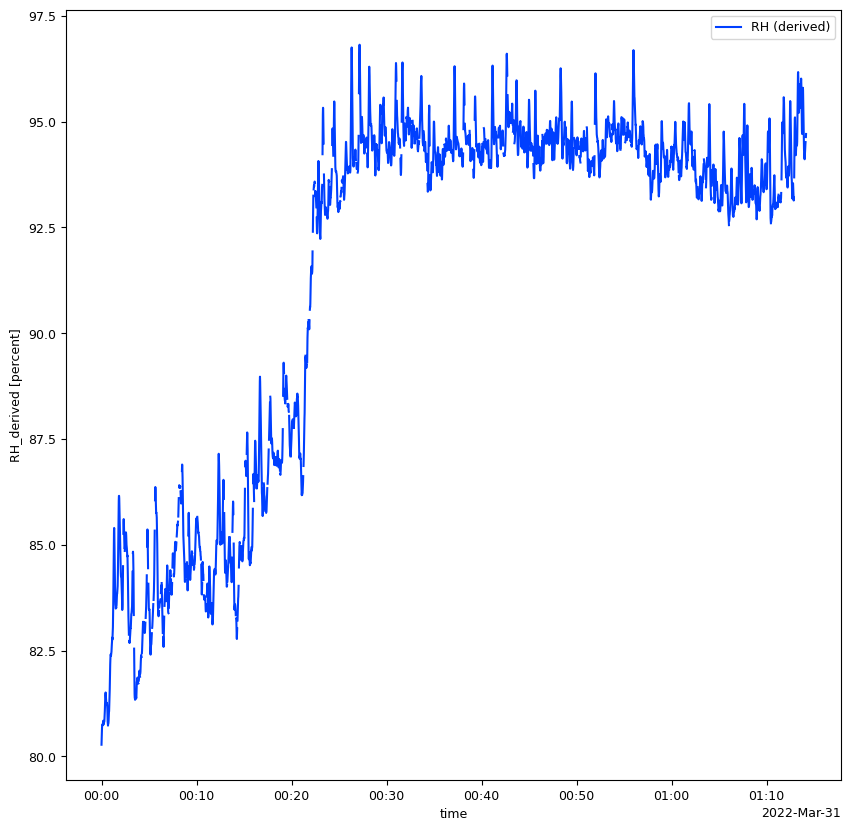

In [65]:
# Sanity check!

PIPS_name = 'PIPS3B'

fig, ax = plt.subplots(figsize=(10, 10))

conv_ds_dict[PIPS_name]['RH_derived'].plot(ax=ax, label='RH (derived)')
ax.legend(loc='best')


In [66]:
# Recompute some of the derived thermodynamic parameters (pt, qv, rho) using the new corrected vars

for PIPS_name in PIPS_names:
    conv_ds_dict[PIPS_name] = pips.calc_thermo(conv_ds_dict[PIPS_name], p_var='pressure', 
                                               T_var='fasttemp', RH_var='RH_derived')

In [67]:
# Now resample the corrected timeseries to the parsivel times. Technically, we could just apply the bias correction
# directly and should get the same result.

corrected_varnames = ['pressure', 'fasttemp', 'slowtemp', 'dewpoint', 'RH', 'RH_derived', 'pt', 'qv', 'rho']

for PIPS_name in PIPS_names:
    # try:
    PSD_datetimes = pips.get_PSD_datetimes(parsivel_ds_dict[PIPS_name]['VD_matrix'])
    sec_offset = PSD_datetimes[0].second
    print(sec_offset)
    offset_str = pips.get_interval_str(sec_offset)
    
    for corrected_varname in corrected_varnames:
        corrected_var = conv_ds_dict[PIPS_name][corrected_varname]
        new_var = corrected_var.resample(time=intervalstr, label='right', closed='right', 
                                         offset=offset_str).mean()
        
        parsivel_ds_dict[PIPS_name][corrected_varname] = new_var
        parsivel_ds_dict[PIPS_name][corrected_varname].attrs = conv_ds_dict[PIPS_name][corrected_varname].attrs
    # except:
    #     print(f"No Parsivel data for {PIPS_name}")

13
43
33
59


In [68]:
# Now do the same for the winds

for PIPS_name in PIPS_names:
    # Resample the winds to the parsivel times and replace the old ones
    try:
        conv_ds = conv_ds_dict[PIPS_name]
        PSD_datetimes = pips.get_PSD_datetimes(parsivel_ds['VD_matrix'])
        sec_offset = PSD_datetimes[0].second
        
        new_wind_dict = pips.resample_wind_da(conv_ds['winddirabs'], conv_ds['windspd'], intervalstr, 
                                              sec_offset, gusts=True, gustintvstr='3S')

        for key, val in new_wind_dict.items():
            parsivel_ds_dict[PIPS_name][key] = val
    except:
        sec_offset = None
        new_wind_dict = None
        print(f"No Parsivel data for {PIPS_to_check}")

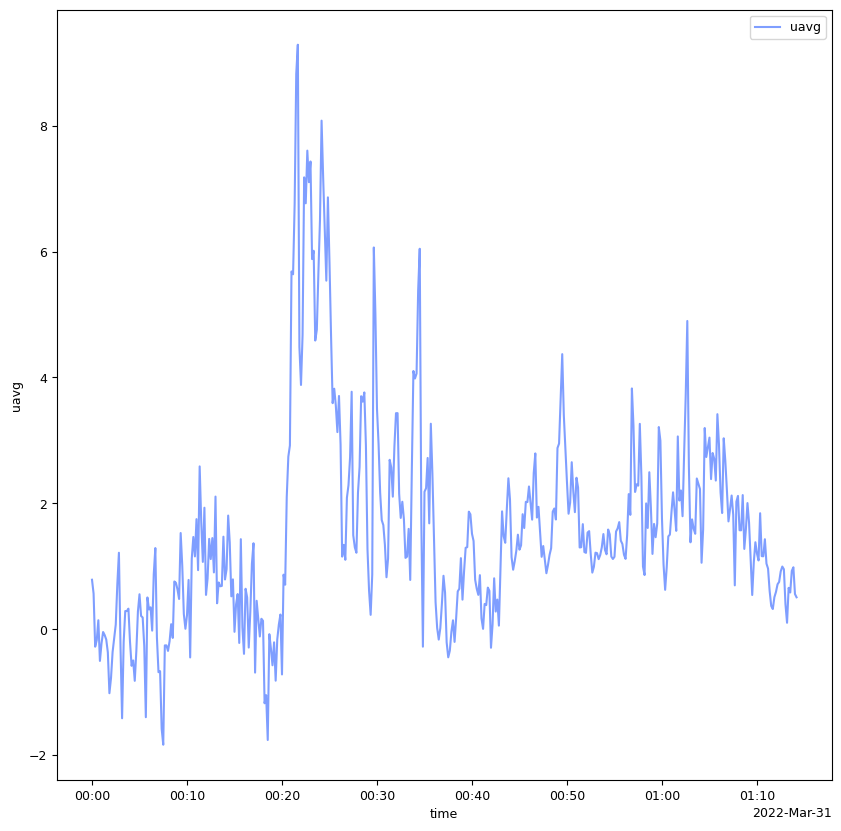

In [69]:
# Sanity check!
fig, ax = comp_var_plot(parsivel_ds_dict['PIPS3B'], varnames=['uavg'], alpha=0.5)

In [70]:
# Now save to new output directory
for PIPS_name, output_parsivel_filepath, output_conv_filepath in zip(PIPS_names, 
                                                                     output_parsivel_filepaths, 
                                                                     output_conv_filepaths):
    print(PIPS_name)
    
    try:
        print("Saving {}".format(output_parsivel_filepath))
        parsivel_ds_dict[PIPS_name].to_netcdf(output_parsivel_filepath)
    except:
        print(f"No Parsivel data for {PIPS_name}")
    print("Saving {}".format(output_conv_filepath))
    conv_ds_dict[PIPS_name].to_netcdf(output_conv_filepath)

PIPS1A
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/parsivel_combined_IOP2_033022_PIPS1A_10s.nc
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/conventional_raw_IOP2_033022_PIPS1A.nc
PIPS1B
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/parsivel_combined_IOP2_033022_PIPS1B_10s.nc
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/conventional_raw_IOP2_033022_PIPS1B.nc
PIPS2A
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/parsivel_combined_IOP2_033022_PIPS2A_10s.nc
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/conventional_raw_IOP2_033022_PIPS2A.nc
PIPS3B
Saving /Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf_bias_corrected/parsivel_combined_IOP2_033022_PIPS3B_10s.nc
Saving 

In [ ]:
# OLD CELLS BELOW

In [ ]:
# Figure out how to average winds. We can just take the direct average of the wind speeds, gust speeds, and u and v components
# The rest we re-compute from the averaged u and v components
var_da_dict = {}
for var in ['windspd', 'windgust', 'uavg', 'vavg']:
    var_da_dict[var] = combined_parsivel_ds[var].mean(dim='PIPS', skipna=True)

# Compute vector average wind speed
var_da_dict['windspdavgvec'] = np.sqrt(var_da_dict['uavg']**2. + var_da_dict['vavg']**2.)
# Compute vector average wind direction
var_da_dict['winddirabs'] = (270.0 - (180. / np.pi) * np.arctan2(var_da_dict['vavg'], var_da_dict['uavg'])) % 360.

# Compute unit average wind speed/direction
unit_u = combined_parsivel_ds['uavg'] / combined_parsivel_ds['windspd']
unit_v = combined_parsivel_ds['vavg'] / combined_parsivel_ds['windspd']
unit_u_avg = unit_u.mean(dim='PIPS', skipna=True)
unit_v_avg = unit_v.mean(dim='PIPS', skipna=True)

wind_dir_unit_vec_avg = (270.0 - (180. / np.pi) * np.arctan2(unit_v_avg, unit_u_avg)) % 360.
wind_dir_unit_vec_avg = xr.where((unit_u_avg == 0.) & (unit_v_avg == 0.), np.nan, wind_dir_unit_vec_avg)

var_da_dict['unit_uavg'] = unit_u_avg
var_da_dict['unit_vavg'] = unit_v_avg
var_da_dict['winddirunitavgvec'] = wind_dir_unit_vec_avg


In [ ]:
var = 'winddirunitavgvec'

fig, ax = plt.subplots(figsize=(10, 8))
var_da_dict[var].plot(ax=ax, label='avg')
combined_parsivel_ds.sel(PIPS='PIPS1A')[var].plot(ax=ax, label='PIPS1A')
combined_parsivel_ds.sel(PIPS='PIPS1B')[var].plot(ax=ax, label='PIPS1B')
combined_parsivel_ds.sel(PIPS='PIPS2A')[var].plot(ax=ax, label='PIPS2A')
combined_parsivel_ds.sel(PIPS='PIPS3B')[var].plot(ax=ax, label='PIPS3B')
ax.legend(loc='best')

In [ ]:
# Sanity check

spd = np.sqrt(var_da_dict['unit_uavg']**2. + var_da_dict['unit_vavg']**2.)
spd.plot()

In [ ]:
spd = np.sqrt(combined_parsivel_ds.sel(PIPS='PIPS1A')['unit_uavg']**2. + combined_parsivel_ds.sel(PIPS='PIPS1A')['unit_vavg']**2.)
spd.plot()

In [ ]:

# Compute the average across the 'PIPS' dimension
parsivel_average_ds = combined_parsivel_ds.mean(dim='PIPS')


In [ ]:
combined_parsivel_ds

In [ ]:
new_new_parsivel_dict = {}
for PIPS_name in PIPS_names:
    new_new_parsivel_dict[PIPS_name] = combined_parsivel_ds.sel(PIPS=PIPS_name)

In [ ]:
fig, ax = comp_plot(PIPS_names, new_new_parsivel_dict, 'fasttemp', alpha=0.5, x='relative_time')

In [ ]:
fig, ax = plt.subplots()
parsivel_average_ds['fasttemp'].plot(ax=ax, x='relative_time')

# Format the x-axis
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(time_formatter))
ax.set_xlabel('Time since gust front passage (s)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(900.))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(300.))


In [ ]:
PSD_times = parsivel_average_ds['relative_time']
PSD_times_dict = pips.get_PSD_time_bins(PSD_times)


PSD_times_dict['PSD_datetimes_edges'].astype('timedelta64[s]').astype('int')


In [ ]:
# Compute polarimetric fields from PIPS DSDs
dD = parsivel_average_ds['max_diameter'] - parsivel_average_ds['min_diameter']
dualpol_dict_PIPS_avg = dualpol.calpolrain_bulk_xr(10.7, 
                                                   '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                                   parsivel_average_ds['ND_roqc'], dD, diameter_bin_name='diameter_bin')

In [ ]:
dualpol_dict_PIPS_avg.keys()

dualpol_dict_PIPS_avg['REF']

In [ ]:
# Plot observed DSD meteograms

ND_PIPS = parsivel_average_ds['ND_roqc']
# ND_PIPS = combined_parsivel_ds.sel(PIPS='PIPS3B')['ND_roqc']
ZH_PIPS = dualpol_dict_PIPS_avg['REF']
ZH_rad = parsivel_average_ds['KGWX_at_PIPS'].loc[{'fields_KGWX': 'REF_filtered'}]

# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND_PIPS['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_max_ind, D_range)
ND_trunc = ND_PIPS.isel(diameter_bin=slice(0, D_max_ind))

PSD_datetimes_PIPS = parsivel_average_ds['relative_time']  # pips.get_PSD_datetimes(ND_PIPS)
PSD_datetimes_PIPS_dict = pips.get_PSD_time_bins(PSD_datetimes_PIPS)
# PSDstarttimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_centers'])

# Gotcha! For some reason the following only works because the dictionary entries are numpy arrays, not xarray DataArrays.
# If they are the latter, I suppose we would have to extract the underlying numpy array, recast it, and then save the data back
# to the original DataArray
PSDstarttimes = PSD_datetimes_PIPS_dict['PSD_datetimes_edges'].astype('timedelta64[s]').astype('int')
PSDmidtimes = PSD_datetimes_PIPS_dict['PSD_datetimes_centers'].astype('timedelta64[s]').astype('int')

plot_start_datetime = PSDstarttimes[0]
plot_end_datetime = PSDstarttimes[-1]

# Prepare axis parameters
timelimits = [plot_start_datetime, plot_end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = ticker.MultipleLocator(900) # dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = ticker.MultipleLocator(300) # dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = None #  dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

logND = np.log10(ND_trunc)
logND = logND.where(logND > -1.0)

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!

# D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
# dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
# ZDR = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']

diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
diameter_bin_edges = diameter_bin_edges[:D_max_ind+1]

disvars = {'diameter_bin_edges': diameter_bin_edges, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'REF': ZH_PIPS} # , 'D_m': Dm_sorted_PIPS_da, 'dBZ': ZH_sorted_PIPS_da, 
           # 'ZDR': ZDR_sorted_PIPS_da}

# radvars = None
radvars = {'radmidtimes': PSDmidtimes, 'REF': ZH_rad}

plot_dir = './'
dis_plot_name = 'PIPSAVG_' + DSDtype
PIPSplot.plotDSDmeteograms(dis_plot_name, plot_dir, axparams, disvars, radvars=radvars, close_fig=False, use_plot_date=False)

In [ ]:
parsivel_average_ds